# Подгрузка библиотек и функции

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sn
import pandas as pd
from tensorflow.keras.models import model_from_json
from keras import backend as K
import json

In [4]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# (ДАННЫЙ КОД ДЛЯ JUPYTER LAB)
from IPython.display import display, HTML, clear_output # Если скучно то можно понаблюдать за обучением))
import time  # в начале файла

def progress(value, max=100, acc=0, loss=0):
    percent = int(value / max * 100)
    return HTML(f"""
        <div style="font-family: monospace; width: 50%;">
            <div style="display: flex; align-items: center; gap: 10px;">
                <div>Batch progress: {value}/{max} ({percent}%)</div>
                <progress value='{value}' max='{max}' style='flex-grow: 1; height: 20px;'></progress>
                <div>Accuracy: {acc:.4f} | Loss: {loss:.4f}</div>
            </div>
        </div>
    """)

In [6]:
# Функция для обучения модели
def my_train_loop(
    model, 
    epochs, 
    batch_size, 
    optimizer, 
    loss_fn, 
    x_data, 
    y_data, 
    acc_metric = tf.keras.metrics.CategoricalAccuracy(),
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy(),
    val_split = 0.2
    ):

    x_train, x_val, y_train, y_val = train_test_split(
        x_data, y_data, test_size=val_split, shuffle=True
    )
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size) # Для обучения модели
    if len(y_val.shape) == 1:
        y_val = tf.reshape(y_val, (-1, 1)) 

    total_steps = tf.data.experimental.cardinality(dataset).numpy() 
    prog_display = display(progress(0, total_steps, 0, 0), display_id=True)
    hist_data = []
    
    for epoch in range(epochs):
        epoch_loss = 0

        for step, (x_batch, y_batch) in enumerate(dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)
    
            # Градиенты и шаг оптимизации
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Метрики на каждом батче
            acc_metric.update_state(y_batch, predictions)
            epoch_loss += loss.numpy()
            prog_display.update(progress(step+1, total_steps, acc_metric.result().numpy(), loss.numpy()))

        # Расчет метрик по трейну
        acc = acc_metric.result().numpy()
        avg_loss = epoch_loss / (step + 1)
        acc_metric.reset_state()

        # Расчет метрик на валидации
        predictions = model(x_val, training=False)
        val_acc_metric.update_state(y_val, predictions)
        val_acc = val_acc_metric.result().numpy()
        
        val_loss = loss_fn(y_val, predictions)
        
        hist_data.append(np.array([acc, val_acc, avg_loss, val_loss]))
        print(f"Epoch {epoch+1}/{epochs}   Train Accuracy: {acc:.6f} Train Loss: {avg_loss:.6f}   Val Accuracy: {val_acc:.6f} Val Loss: {val_loss:.6f}")
    return np.array(hist_data)

In [7]:
# Вывод кривых обучения
def plot_training_history(hist_data):
    epochs_range = range(1, len(hist_data) + 1)

    plt.figure(figsize=(12, 5))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, hist_data[:, 0], label='Train Accuracy')
    plt.plot(epochs_range, hist_data[:, 1], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, hist_data[:, 2], label='Train Loss')
    plt.plot(epochs_range, hist_data[:, 3], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
#функция вывода матрицы точности
def Confusion_Matrix( model, testX, testY, dataset_labels=np.array(['DOOM','ANIMAL']), Title= "CONFUSION MATRIX"):
  
  # Confusion Matrix
  predictions = model(testX, training=False).numpy()
  if predictions.shape[1] > 1:
        # Многоклассовая классификация / one-hot
        predictions = np.argmax(predictions, axis=1)
  else:
        # Бинарная классификация с вероятностями
        predictions = (predictions > 0.5).astype(int).flatten()

  if len(testY.shape) > 1 and testY.shape[1] > 1:
        # Если тестовые метки в one-hot формате
        testY = np.argmax(testY, axis=1)
  else:
        testY = testY.flatten()
  confusion = confusion_matrix(testY, 
                              predictions)
  # normalize confustion matrix [0 1]
  # confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
  df_cm = pd.DataFrame(confusion, 
                       dataset_labels, 
                       dataset_labels)
  sn.set(font_scale=1.2) # for label size
  plt.figure(figsize=(4,4))
  sn.heatmap(df_cm, 
             annot=True, 
             annot_kws={"size": 10}, # font size
             fmt = "d",
             #fmt='.2f', # precision (2 digits)
             linewidths=.5,
             cmap="YlGnBu") 
  plt.title(Title)
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

  print('CLASSIFICATION REPORT\n',
        classification_report(testY, 
                              predictions, 
                              target_names=dataset_labels))

In [9]:
# Сохраняет модель в виде двух файлов (веса и архитектура)
# т.к. используется самописный цикл, то стандартный метод 
# (требующий компиляции) не подойдет
def save_custom_model(model, path):
    # Создание папки, если нужно
    os.makedirs(os.path.dirname(path), exist_ok=True)

    # Сохранение архитектуры
    json_config = model.to_json()
    with open(f'{path}.json', 'w') as json_file:
        json_file.write(json_config)

    # Сохранение весов
    model.save_weights(f'{path}_weights.h5')


def load_custom_model(path):

    with open(f'{path}.json', 'r') as json_file:
        json_config = json_file.read()

    model = model_from_json(json_config)
    model.load_weights(f'{path}_weights.h5')
    return model

# MNIST

## MLP

In [29]:
# НАбор данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Для подачи в MLP модель изображение вытягивается в вектор, а значения пикселей нормализуются
x_train = x_train.reshape(-1, 784).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 784).astype(np.float32) / 255.0

# Преобразуем числа в бинарные массивы, где каждая позиция означает принадлежность к классу
# т. е. каждая строка — это вероятности по классам
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [30]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation='relu', input_shape=(28*28,)),
        tf.keras.layers.Dense(32, activation='relu'),   
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam()  #tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()


# Параметры цикла
epochs = 40
batch_size = 2000

with tf.device('/GPU:0'):
    hist = my_train_loop(model, epochs, batch_size, optimizer, loss_fn, x_train, y_train)

Epoch 1/40   Train Accuracy: 0.982354 Train Loss: 0.003029   Val Accuracy: 0.981833 Val Loss: 0.003057
Epoch 2/40   Train Accuracy: 0.984771 Train Loss: 0.002726   Val Accuracy: 0.981500 Val Loss: 0.003176
Epoch 3/40   Train Accuracy: 0.985667 Train Loss: 0.002614   Val Accuracy: 0.981250 Val Loss: 0.003196
Epoch 4/40   Train Accuracy: 0.986479 Train Loss: 0.002489   Val Accuracy: 0.981083 Val Loss: 0.003221
Epoch 5/40   Train Accuracy: 0.987333 Train Loss: 0.002376   Val Accuracy: 0.981017 Val Loss: 0.003265
Epoch 6/40   Train Accuracy: 0.987979 Train Loss: 0.002290   Val Accuracy: 0.980778 Val Loss: 0.003321
Epoch 7/40   Train Accuracy: 0.988292 Train Loss: 0.002223   Val Accuracy: 0.980548 Val Loss: 0.003390
Epoch 8/40   Train Accuracy: 0.988583 Train Loss: 0.002161   Val Accuracy: 0.980323 Val Loss: 0.003444


KeyboardInterrupt: 

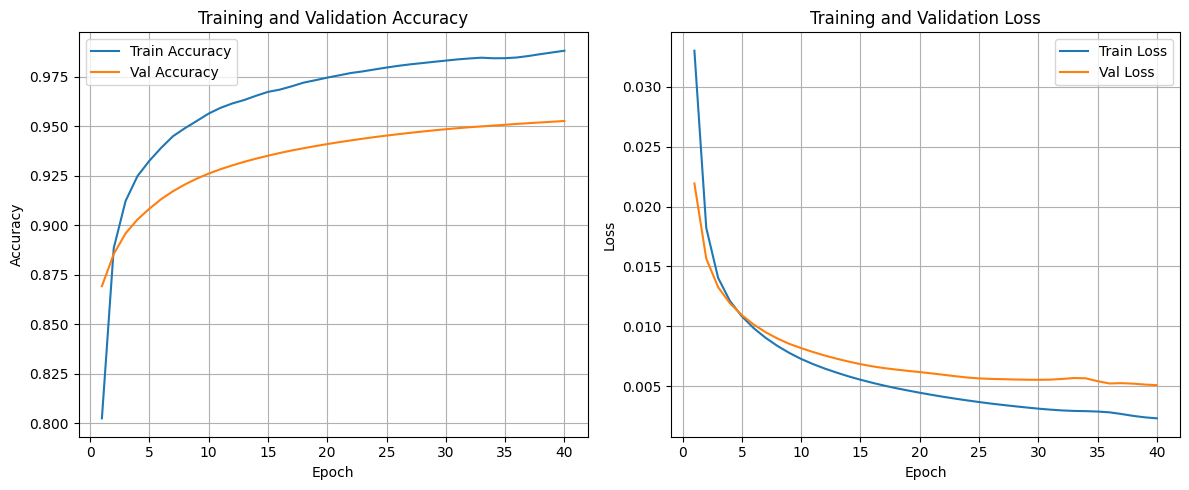

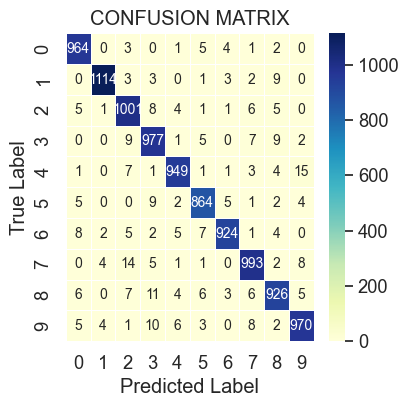

CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.96      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [52]:
plot_training_history(hist)
Confusion_Matrix(model, x_test, y_test, np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

## CNN

In [82]:
# НАбор данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Для подачи в MLP модель изображение вытягивается в вектор, а значения пикселей нормализуются
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Преобразуем числа в бинарные массивы, где каждая позиция означает принадлежность к классу
# т. е. каждая строка — это вероятности по классам
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [83]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),  # MNIST: 28x28x1 (grayscale)

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # Размерность после предыдущих слоёв уже мала, можно не делать ещё один MaxPooling

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # MNIST: 10 классов
])

model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [84]:
# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam()  #tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()


# Параметры цикла
epochs = 40
batch_size = 2000

with tf.device('/GPU:0'):
    hist = my_train_loop(model_cnn, epochs, batch_size, optimizer, loss_fn, x_train, y_train)

Epoch 1/40   Train Accuracy: 0.666188 Train Loss: 0.054615   Val Accuracy: 0.854000 Val Loss: 0.021503
Epoch 2/40   Train Accuracy: 0.890542 Train Loss: 0.016397   Val Accuracy: 0.885625 Val Loss: 0.012475
Epoch 3/40   Train Accuracy: 0.935875 Train Loss: 0.009941   Val Accuracy: 0.907500 Val Loss: 0.007568
Epoch 4/40   Train Accuracy: 0.960271 Train Loss: 0.006336   Val Accuracy: 0.922354 Val Loss: 0.005289
Epoch 5/40   Train Accuracy: 0.971625 Train Loss: 0.004604   Val Accuracy: 0.932600 Val Loss: 0.004027
Epoch 6/40   Train Accuracy: 0.976438 Train Loss: 0.003764   Val Accuracy: 0.940097 Val Loss: 0.003437
Epoch 7/40   Train Accuracy: 0.980125 Train Loss: 0.003209   Val Accuracy: 0.945857 Val Loss: 0.003007
Epoch 8/40   Train Accuracy: 0.982667 Train Loss: 0.002800   Val Accuracy: 0.950333 Val Loss: 0.002822
Epoch 9/40   Train Accuracy: 0.984958 Train Loss: 0.002442   Val Accuracy: 0.954065 Val Loss: 0.002489
Epoch 10/40   Train Accuracy: 0.986188 Train Loss: 0.002232   Val Accurac

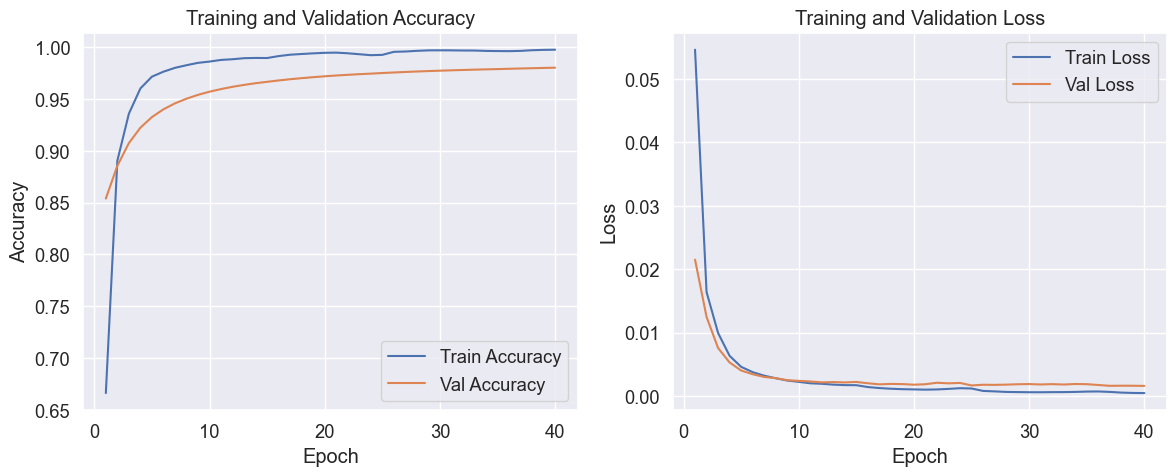

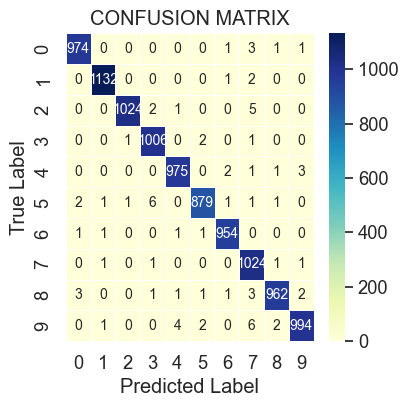

CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      1.00      0.99       958
           7       0.98      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [86]:
plot_training_history(hist)
Confusion_Matrix(model_cnn, x_test, y_test, np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

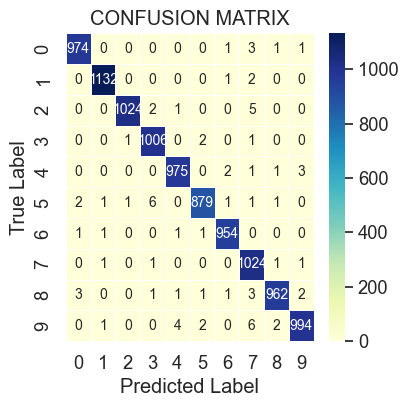

CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      1.00      0.99       958
           7       0.98      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [91]:
save_custom_model(model_cnn, "C:\\Users\\dimag\\custom_model_mnist")
model_cnn_2 = load_custom_model("C:\\Users\\dimag\\custom_model_mnist")
Confusion_Matrix(model_cnn_2, x_test, y_test, np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

## RNN

In [115]:
# НАбор данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Для подачи в MLP модель изображение вытягивается в вектор, а значения пикселей нормализуются
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Преобразуем числа в бинарные массивы, где каждая позиция означает принадлежность к классу
# т. е. каждая строка — это вероятности по классам
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [120]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),                     # 28 временных шагов по 28 признаков
    tf.keras.layers.SimpleRNN(128, activation='tanh'),         # можно заменить на LSTM/GRU
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')            # 10 выходов — по числу классов
])


model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [121]:
# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam()  #tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()


# Параметры цикла
epochs = 40
batch_size = 2000

with tf.device('/GPU:0'):
    hist = my_train_loop(model_rnn, epochs, batch_size, optimizer, loss_fn, x_train, y_train)

Epoch 1/40   Train Accuracy: 0.515771 Train Loss: 0.065841   Val Accuracy: 0.976550 Val Loss: 0.039311
Epoch 2/40   Train Accuracy: 0.823021 Train Loss: 0.027469   Val Accuracy: 0.974113 Val Loss: 0.020574
Epoch 3/40   Train Accuracy: 0.892458 Train Loss: 0.016360   Val Accuracy: 0.972530 Val Loss: 0.015241
Epoch 4/40   Train Accuracy: 0.918312 Train Loss: 0.012703   Val Accuracy: 0.971337 Val Loss: 0.013033
Epoch 5/40   Train Accuracy: 0.931104 Train Loss: 0.010730   Val Accuracy: 0.970330 Val Loss: 0.011842
Epoch 6/40   Train Accuracy: 0.938333 Train Loss: 0.009650   Val Accuracy: 0.969519 Val Loss: 0.010628
Epoch 7/40   Train Accuracy: 0.944292 Train Loss: 0.008722   Val Accuracy: 0.968794 Val Loss: 0.010200
Epoch 8/40   Train Accuracy: 0.946667 Train Loss: 0.008221   Val Accuracy: 0.968202 Val Loss: 0.009338
Epoch 9/40   Train Accuracy: 0.951500 Train Loss: 0.007567   Val Accuracy: 0.967713 Val Loss: 0.008739
Epoch 10/40   Train Accuracy: 0.954625 Train Loss: 0.007080   Val Accurac

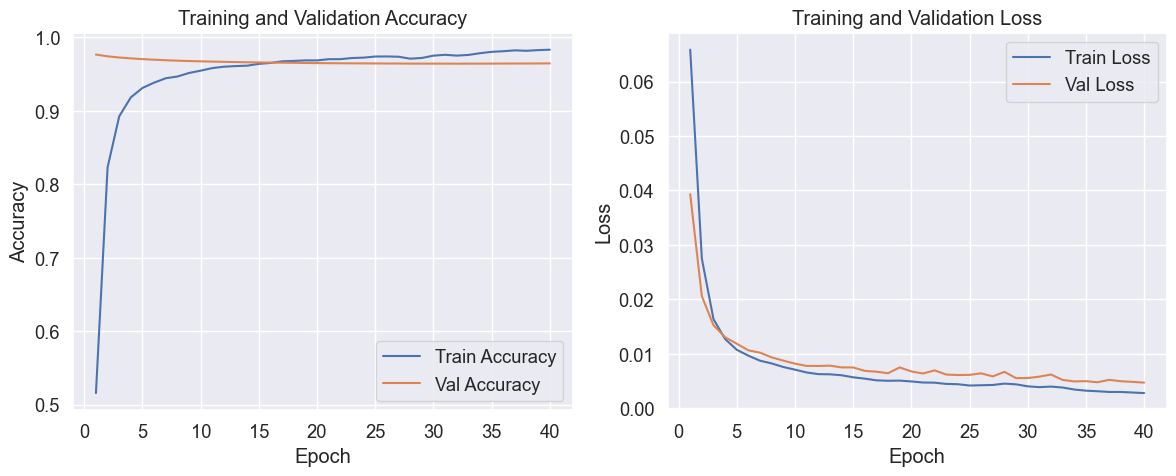

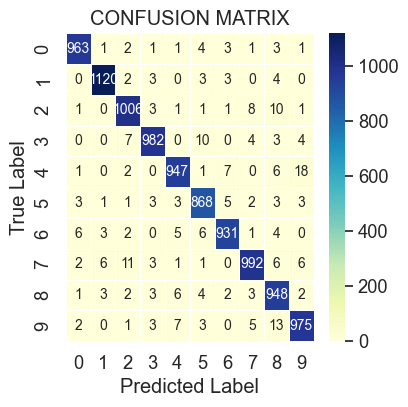

CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.96      0.97       982
           5       0.96      0.97      0.97       892
           6       0.98      0.97      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [122]:
plot_training_history(hist)
Confusion_Matrix(model_rnn, x_test, y_test, np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

# MLP

## Загрузка датасета

In [59]:
# !pip install opendatasets
from sklearn.model_selection import train_test_split
import opendatasets as od
import pandas as pd

In [60]:
# Загрузка датасета (если среда локальная то только один раз)
# data = od.download("https://www.kaggle.com/datasets/andrewmvd/doom-crossing/data")

In [61]:
import os
from PIL import Image

def get_image_stats(folder_path):
    sizes = []
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if not os.path.isdir(cls_path):
            continue
        for fname in os.listdir(cls_path):
            img_path = os.path.join(cls_path, fname)
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)
            except:
                continue
    widths, heights = zip(*sizes)
    return {
        'min_size': (min(widths), min(heights)),
        'max_size': (max(widths), max(heights)),
        'mean_size': (int(np.mean(widths)), int(np.mean(heights))),
        'total_images': len(sizes)
    }

stats = get_image_stats('C:\\Users\\dimag\\doom-crossing')
print(stats)

{'min_size': (230, 177), 'max_size': (8000, 6000), 'mean_size': (1488, 1348), 'total_images': 1597}


In [62]:
data = tf.keras.utils.image_dataset_from_directory(
    'C:\\Users\\dimag\\doom-crossing',
    image_size=(64, 64),
    batch_size=None
)
data = data.map(lambda x,y: (x/255, y))

x_list = []
y_list = []

for x, y in data:
    x_list.append(x.numpy())
    y_list.append(y.numpy())

x_data = np.stack(x_list)
y_data = np.stack(y_list)

Found 1597 files belonging to 2 classes.


In [63]:
split = train_test_split(x_data, y_data, test_size=0.3, random_state=46)
(train_x, test_x, train_y, test_y) = split

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1117, 12288)
(1117,)
(480, 12288)
(480,)


In [64]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(4096, activation='relu', input_shape=(64*64*3,)),  
        tf.keras.layers.Dense(256, activation='relu'),  
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 4096)              50335744  
                                                                 
 dense_18 (Dense)            (None, 256)               1048832   
                                                                 
 dense_19 (Dense)            (None, 16)                4112      
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 51,388,705
Trainable params: 51,388,705
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
ac = tf.keras.metrics.BinaryAccuracy()

# Параметры цикла
epochs = 100
batch_size = 50

with tf.device('/GPU:0'):
    hist = my_train_loop(model, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac, ac)

Epoch 1/100   Train Accuracy: 0.762598 Train Loss: 0.535428   Val Accuracy: 0.745536 Val Loss: 0.553776
Epoch 2/100   Train Accuracy: 0.803939 Train Loss: 0.464606   Val Accuracy: 0.741071 Val Loss: 0.548855
Epoch 3/100   Train Accuracy: 0.811996 Train Loss: 0.445215   Val Accuracy: 0.745536 Val Loss: 0.555034
Epoch 4/100   Train Accuracy: 0.820949 Train Loss: 0.422668   Val Accuracy: 0.741071 Val Loss: 0.568053
Epoch 5/100   Train Accuracy: 0.824530 Train Loss: 0.405304   Val Accuracy: 0.723214 Val Loss: 0.582579
Epoch 6/100   Train Accuracy: 0.839749 Train Loss: 0.381257   Val Accuracy: 0.718750 Val Loss: 0.593229
Epoch 7/100   Train Accuracy: 0.848702 Train Loss: 0.356508   Val Accuracy: 0.727679 Val Loss: 0.582008
Epoch 8/100   Train Accuracy: 0.863026 Train Loss: 0.333941   Val Accuracy: 0.732143 Val Loss: 0.566884
Epoch 9/100   Train Accuracy: 0.875560 Train Loss: 0.314678   Val Accuracy: 0.732143 Val Loss: 0.566496
Epoch 10/100   Train Accuracy: 0.889884 Train Loss: 0.295393   V

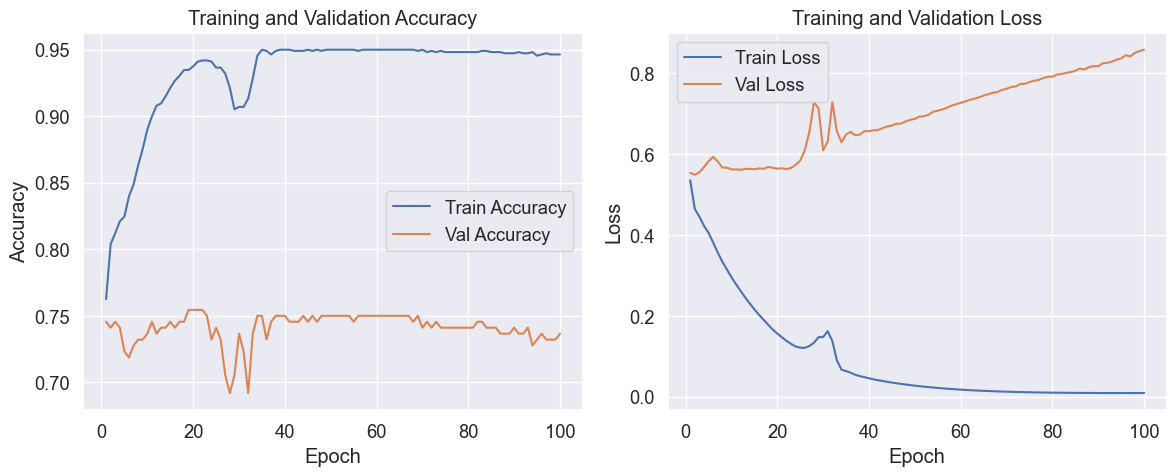

In [73]:
plot_training_history(hist)

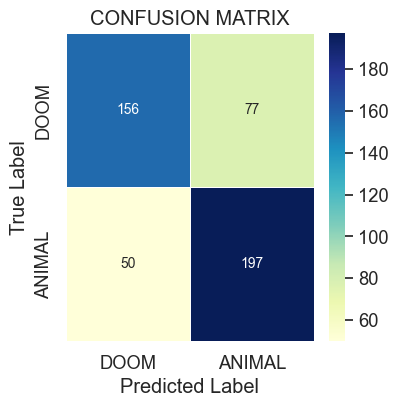

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.76      0.67      0.71       233
      ANIMAL       0.72      0.80      0.76       247

    accuracy                           0.74       480
   macro avg       0.74      0.73      0.73       480
weighted avg       0.74      0.74      0.73       480



In [74]:
Confusion_Matrix(model, test_x, test_y)

## тестирование моделей

### Начальные параметры обучения

In [55]:
# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
ac = tf.keras.metrics.BinaryAccuracy()

# Параметры цикла
epochs = 100
batch_size = 100

### MODEL 1

In [57]:
model1 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(4096, activation='relu', input_shape=(64*64*3,)),  
        tf.keras.layers.Dense(256, activation='relu'),  
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 4096)              50335744  
                                                                 
 dense_14 (Dense)            (None, 256)               1048832   
                                                                 
 dense_15 (Dense)            (None, 16)                4112      
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 51,388,705
Trainable params: 51,388,705
Non-trainable params: 0
_________________________________________________________________


In [58]:
with tf.device('/GPU:0'):
    hist = my_train_loop(model1, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac, ac)

NameError: name 'train_x' is not defined

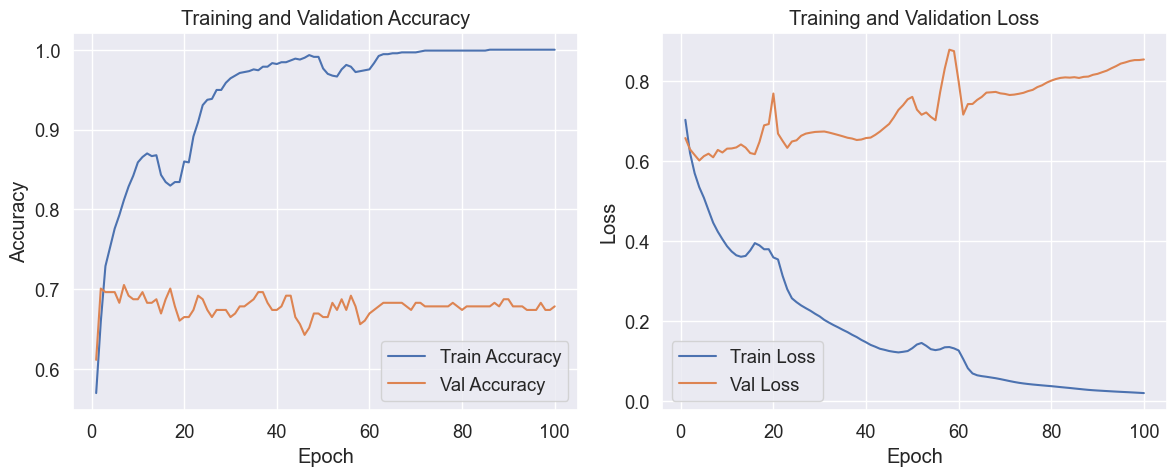

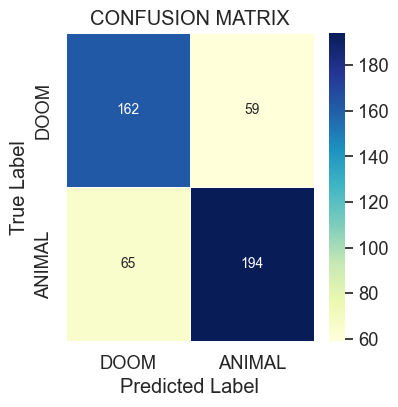

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.71      0.73      0.72       221
      ANIMAL       0.77      0.75      0.76       259

    accuracy                           0.74       480
   macro avg       0.74      0.74      0.74       480
weighted avg       0.74      0.74      0.74       480



In [180]:
plot_training_history(hist)
Confusion_Matrix(model1, test_x, test_y)

### MODEL 2

In [181]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='tanh', input_shape=(12288,)),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 1024)              12583936  
                                                                 
 dense_82 (Dense)            (None, 128)               131200    
                                                                 
 dense_83 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,715,265
Trainable params: 12,715,265
Non-trainable params: 0
_________________________________________________________________


In [182]:
with tf.device('/GPU:0'):
    hist = my_train_loop(model2, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac)

Epoch 1/100   Train Accuracy: 0.517357 Train Loss: 0.905967   Val Accuracy: 0.482143 Val Loss: 0.753775
Epoch 2/100   Train Accuracy: 0.642777 Train Loss: 0.632283   Val Accuracy: 0.687500 Val Loss: 0.599135
Epoch 3/100   Train Accuracy: 0.678611 Train Loss: 0.593710   Val Accuracy: 0.687500 Val Loss: 0.591891
Epoch 4/100   Train Accuracy: 0.714446 Train Loss: 0.566489   Val Accuracy: 0.691964 Val Loss: 0.568785
Epoch 5/100   Train Accuracy: 0.734602 Train Loss: 0.537657   Val Accuracy: 0.696429 Val Loss: 0.558517
Epoch 6/100   Train Accuracy: 0.744681 Train Loss: 0.522268   Val Accuracy: 0.705357 Val Loss: 0.549087
Epoch 7/100   Train Accuracy: 0.754759 Train Loss: 0.509732   Val Accuracy: 0.709821 Val Loss: 0.543894
Epoch 8/100   Train Accuracy: 0.767077 Train Loss: 0.496078   Val Accuracy: 0.705357 Val Loss: 0.539270
Epoch 9/100   Train Accuracy: 0.771557 Train Loss: 0.482692   Val Accuracy: 0.709821 Val Loss: 0.535527
Epoch 10/100   Train Accuracy: 0.781635 Train Loss: 0.471055   V

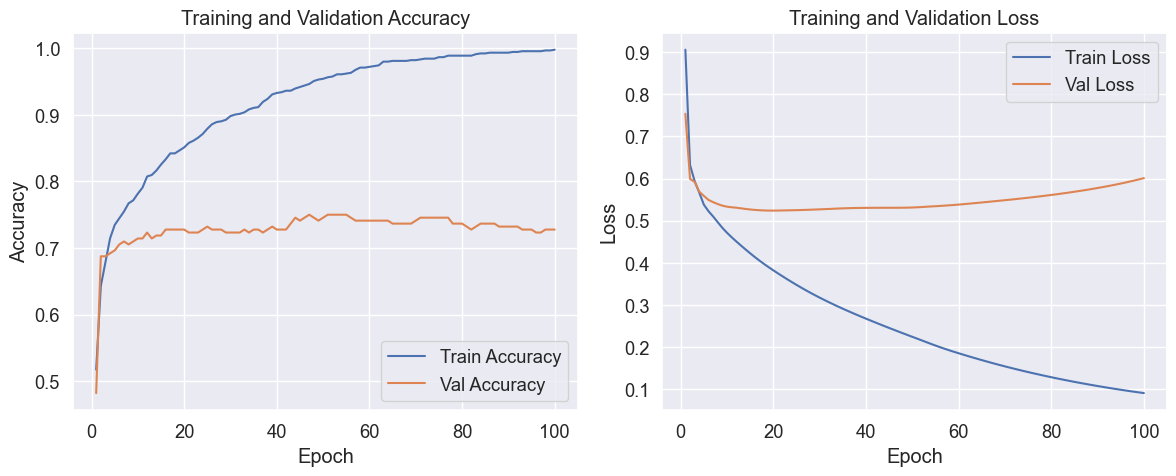

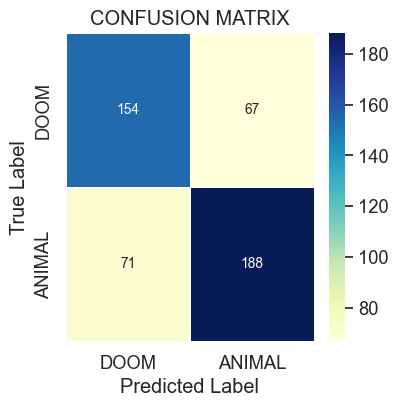

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.68      0.70      0.69       221
      ANIMAL       0.74      0.73      0.73       259

    accuracy                           0.71       480
   macro avg       0.71      0.71      0.71       480
weighted avg       0.71      0.71      0.71       480



In [183]:
plot_training_history(hist)
Confusion_Matrix(model2, test_x, test_y)

### MODEL 3

In [184]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(2048, activation='relu', input_shape=(12288,)),
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model3.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 2048)              25167872  
                                                                 
 dense_85 (Dense)            (None, 512)               1049088   
                                                                 
 dense_86 (Dense)            (None, 128)               65664     
                                                                 
 dense_87 (Dense)            (None, 1)                 129       
                                                                 
Total params: 26,282,753
Trainable params: 26,282,753
Non-trainable params: 0
_________________________________________________________________


In [185]:
with tf.device('/GPU:0'):
    hist = my_train_loop(model3, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac)

Epoch 1/100   Train Accuracy: 0.531915 Train Loss: 0.814567   Val Accuracy: 0.468750 Val Loss: 0.755080
Epoch 2/100   Train Accuracy: 0.634938 Train Loss: 0.631318   Val Accuracy: 0.486607 Val Loss: 0.707828
Epoch 3/100   Train Accuracy: 0.684211 Train Loss: 0.578210   Val Accuracy: 0.553571 Val Loss: 0.665684
Epoch 4/100   Train Accuracy: 0.705487 Train Loss: 0.548574   Val Accuracy: 0.584821 Val Loss: 0.670483
Epoch 5/100   Train Accuracy: 0.726764 Train Loss: 0.534749   Val Accuracy: 0.558036 Val Loss: 0.674281
Epoch 6/100   Train Accuracy: 0.722284 Train Loss: 0.534578   Val Accuracy: 0.683036 Val Loss: 0.570281
Epoch 7/100   Train Accuracy: 0.721165 Train Loss: 0.532585   Val Accuracy: 0.745536 Val Loss: 0.536202
Epoch 8/100   Train Accuracy: 0.739082 Train Loss: 0.515585   Val Accuracy: 0.736607 Val Loss: 0.523001
Epoch 9/100   Train Accuracy: 0.769317 Train Loss: 0.479547   Val Accuracy: 0.736607 Val Loss: 0.519310
Epoch 10/100   Train Accuracy: 0.778275 Train Loss: 0.458414   V

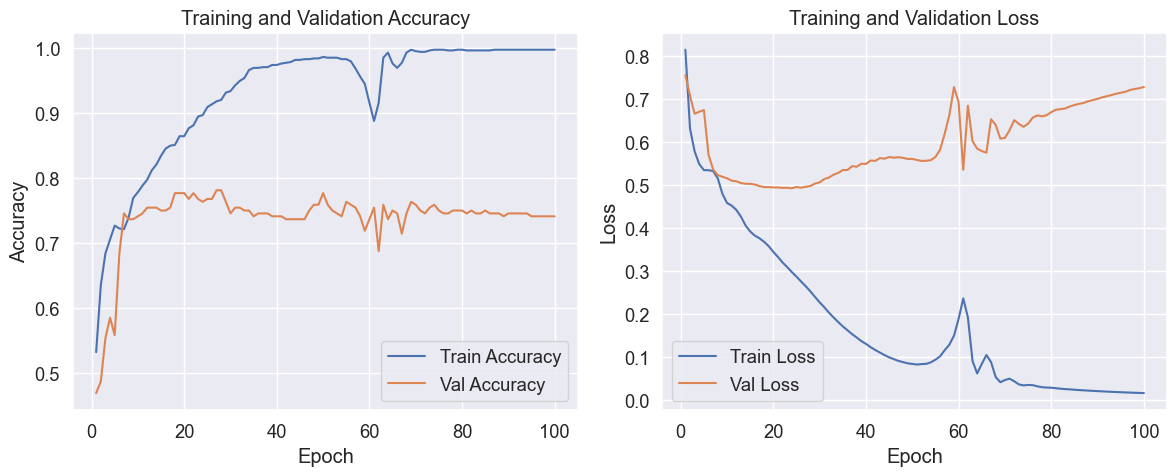

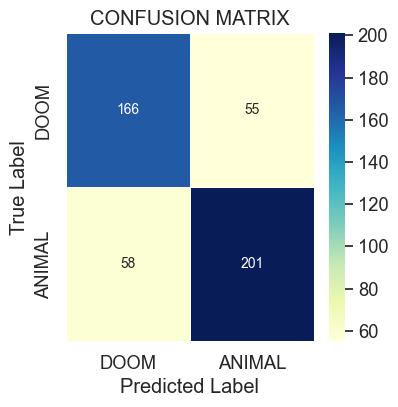

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.74      0.75      0.75       221
      ANIMAL       0.79      0.78      0.78       259

    accuracy                           0.76       480
   macro avg       0.76      0.76      0.76       480
weighted avg       0.76      0.76      0.76       480



In [186]:
plot_training_history(hist)
Confusion_Matrix(model3, test_x, test_y)

### MODEL 4

In [187]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(12288,)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model4.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 512)               6291968   
                                                                 
 dense_89 (Dense)            (None, 64)                32832     
                                                                 
 dense_90 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,324,865
Trainable params: 6,324,865
Non-trainable params: 0
_________________________________________________________________


In [188]:
with tf.device('/GPU:0'):
    hist = my_train_loop(model4, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac)

Epoch 1/100   Train Accuracy: 0.484882 Train Loss: 0.724971   Val Accuracy: 0.540179 Val Loss: 0.678912
Epoch 2/100   Train Accuracy: 0.606943 Train Loss: 0.658940   Val Accuracy: 0.638393 Val Loss: 0.642772
Epoch 3/100   Train Accuracy: 0.693169 Train Loss: 0.626145   Val Accuracy: 0.714286 Val Loss: 0.620229
Epoch 4/100   Train Accuracy: 0.706607 Train Loss: 0.605742   Val Accuracy: 0.705357 Val Loss: 0.605737
Epoch 5/100   Train Accuracy: 0.722284 Train Loss: 0.590778   Val Accuracy: 0.709821 Val Loss: 0.593566
Epoch 6/100   Train Accuracy: 0.745801 Train Loss: 0.575938   Val Accuracy: 0.705357 Val Loss: 0.587620
Epoch 7/100   Train Accuracy: 0.752520 Train Loss: 0.564549   Val Accuracy: 0.705357 Val Loss: 0.584065
Epoch 8/100   Train Accuracy: 0.756999 Train Loss: 0.556125   Val Accuracy: 0.709821 Val Loss: 0.581881
Epoch 9/100   Train Accuracy: 0.758119 Train Loss: 0.548794   Val Accuracy: 0.705357 Val Loss: 0.579032
Epoch 10/100   Train Accuracy: 0.768197 Train Loss: 0.541024   V

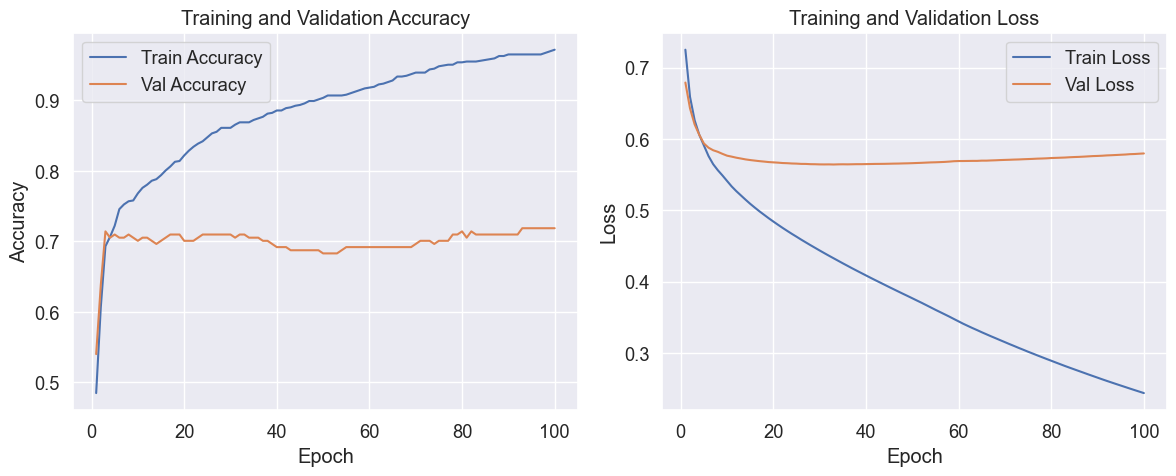

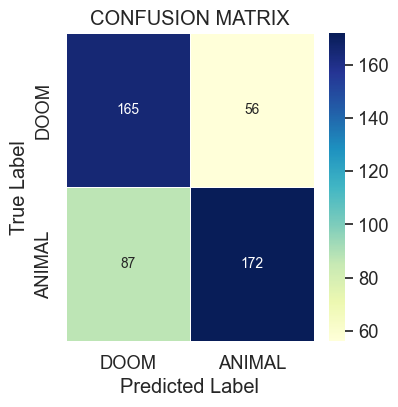

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.65      0.75      0.70       221
      ANIMAL       0.75      0.66      0.71       259

    accuracy                           0.70       480
   macro avg       0.70      0.71      0.70       480
weighted avg       0.71      0.70      0.70       480



In [189]:
plot_training_history(hist)
Confusion_Matrix(model4, test_x, test_y)

# CNN model

### Тестовый запуск

In [93]:
data = tf.keras.utils.image_dataset_from_directory(
    'C:\\Users\\dimag\\doom-crossing',
    image_size=(64, 64),
    batch_size=None
)
data = data.map(lambda x,y: (x/255, y))

x_list = []
y_list = []

for x, y in data:
    x_list.append(x.numpy())
    y_list.append(y.numpy())

x_data = np.stack(x_list)
y_data = np.stack(y_list)

Found 1597 files belonging to 2 classes.


In [97]:
split = train_test_split(x_data, y_data, test_size=0.3, random_state=46)
(train_x, test_x, train_y, test_y) = split

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1117, 64, 64, 3)
(1117,)
(480, 64, 64, 3)
(480,)


In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),# Изображения 64х64 и 3 канала RGB

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 128)       

In [99]:
# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
ac = tf.keras.metrics.BinaryAccuracy()

# Параметры цикла
epochs = 200
batch_size = 50

with tf.device('/GPU:0'):
    hist = my_train_loop(model, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac)

Epoch 1/200   Train Accuracy: 0.517357 Train Loss: 0.693373   Val Accuracy: 0.980297 Val Loss: 0.689348
Epoch 2/200   Train Accuracy: 0.592385 Train Loss: 0.687819   Val Accuracy: 0.980306 Val Loss: 0.686024
Epoch 3/200   Train Accuracy: 0.628219 Train Loss: 0.683443   Val Accuracy: 0.980315 Val Loss: 0.682301
Epoch 4/200   Train Accuracy: 0.696529 Train Loss: 0.678949   Val Accuracy: 0.980324 Val Loss: 0.678100
Epoch 5/200   Train Accuracy: 0.695409 Train Loss: 0.674287   Val Accuracy: 0.980333 Val Loss: 0.673243
Epoch 6/200   Train Accuracy: 0.711086 Train Loss: 0.669354   Val Accuracy: 0.980343 Val Loss: 0.668349
Epoch 7/200   Train Accuracy: 0.717805 Train Loss: 0.664028   Val Accuracy: 0.980352 Val Loss: 0.662678
Epoch 8/200   Train Accuracy: 0.715566 Train Loss: 0.657930   Val Accuracy: 0.980361 Val Loss: 0.656196
Epoch 9/200   Train Accuracy: 0.718925 Train Loss: 0.651097   Val Accuracy: 0.980370 Val Loss: 0.648765
Epoch 10/200   Train Accuracy: 0.717805 Train Loss: 0.643686   V

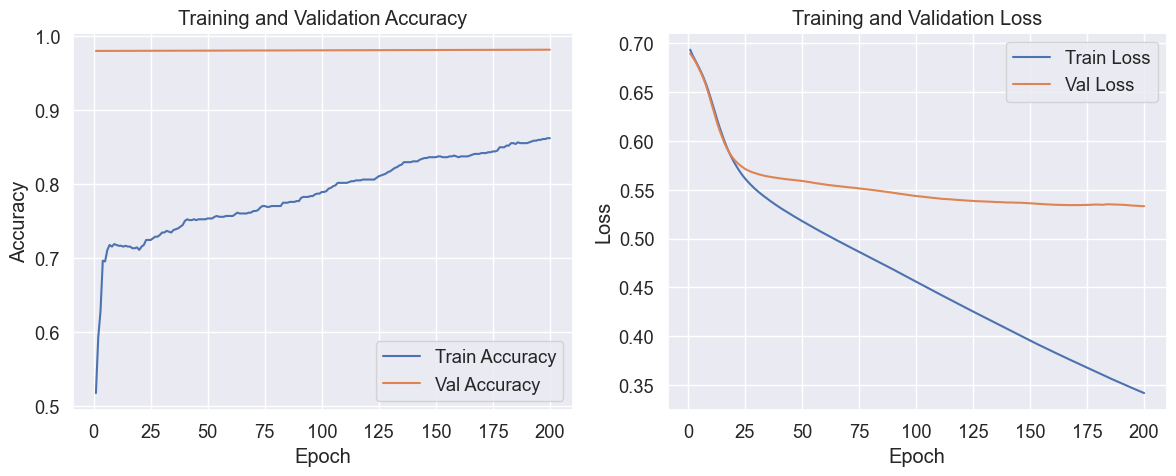

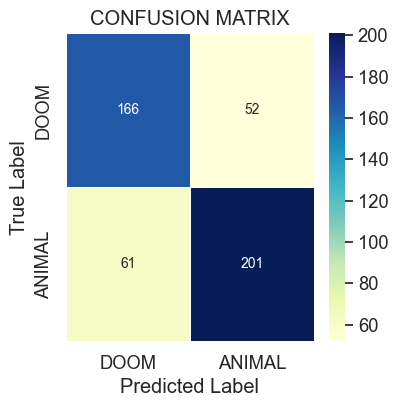

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.73      0.76      0.75       218
      ANIMAL       0.79      0.77      0.78       262

    accuracy                           0.76       480
   macro avg       0.76      0.76      0.76       480
weighted avg       0.77      0.76      0.76       480



In [100]:
plot_training_history(hist)
Confusion_Matrix(model, test_x, test_y)

### Начальные параметры обучения

In [102]:
# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
ac = tf.keras.metrics.BinaryAccuracy()

# Параметры цикла
epochs = 100
batch_size = 100

### MODEL 1

In [103]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


with tf.device('/GPU:0'):
    hist = my_train_loop(model1, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac, ac)

Epoch 1/100   Train Accuracy: 0.545353 Train Loss: 0.690433   Val Accuracy: 0.544643 Val Loss: 0.686319
Epoch 2/100   Train Accuracy: 0.601611 Train Loss: 0.680307   Val Accuracy: 0.651786 Val Loss: 0.677203
Epoch 3/100   Train Accuracy: 0.660698 Train Loss: 0.672236   Val Accuracy: 0.678571 Val Loss: 0.669511
Epoch 4/100   Train Accuracy: 0.686661 Train Loss: 0.664237   Val Accuracy: 0.678571 Val Loss: 0.661115
Epoch 5/100   Train Accuracy: 0.701880 Train Loss: 0.656741   Val Accuracy: 0.705357 Val Loss: 0.653656
Epoch 6/100   Train Accuracy: 0.710833 Train Loss: 0.649414   Val Accuracy: 0.705357 Val Loss: 0.646982
Epoch 7/100   Train Accuracy: 0.712623 Train Loss: 0.642093   Val Accuracy: 0.705357 Val Loss: 0.640003
Epoch 8/100   Train Accuracy: 0.717995 Train Loss: 0.634688   Val Accuracy: 0.696429 Val Loss: 0.632597
Epoch 9/100   Train Accuracy: 0.724261 Train Loss: 0.626783   Val Accuracy: 0.700893 Val Loss: 0.625029
Epoch 10/100   Train Accuracy: 0.719785 Train Loss: 0.618644   V

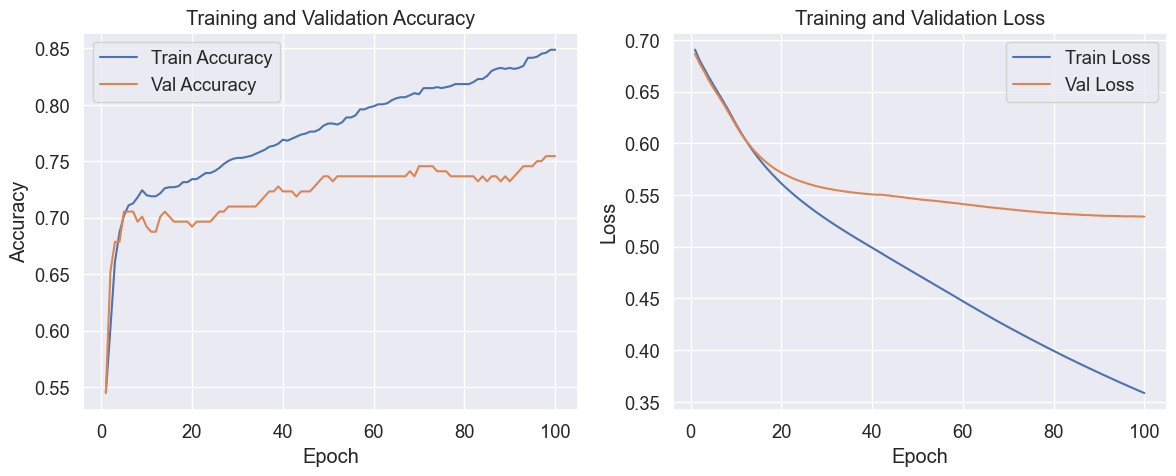

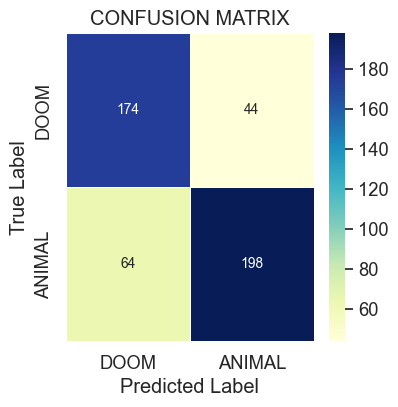

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.73      0.80      0.76       218
      ANIMAL       0.82      0.76      0.79       262

    accuracy                           0.78       480
   macro avg       0.77      0.78      0.77       480
weighted avg       0.78      0.78      0.78       480



In [104]:
plot_training_history(hist)
Confusion_Matrix(model1, test_x, test_y)

### MODEL 2

In [105]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


with tf.device('/GPU:0'):
    hist = my_train_loop(model2, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac, ac)

Epoch 1/100   Train Accuracy: 0.628469 Train Loss: 0.688143   Val Accuracy: 0.696429 Val Loss: 0.675262
Epoch 2/100   Train Accuracy: 0.690242 Train Loss: 0.668661   Val Accuracy: 0.745536 Val Loss: 0.654054
Epoch 3/100   Train Accuracy: 0.706356 Train Loss: 0.648669   Val Accuracy: 0.745536 Val Loss: 0.626915
Epoch 4/100   Train Accuracy: 0.709042 Train Loss: 0.627255   Val Accuracy: 0.750000 Val Loss: 0.599382
Epoch 5/100   Train Accuracy: 0.708147 Train Loss: 0.607700   Val Accuracy: 0.745536 Val Loss: 0.574534
Epoch 6/100   Train Accuracy: 0.709042 Train Loss: 0.592073   Val Accuracy: 0.750000 Val Loss: 0.555184
Epoch 7/100   Train Accuracy: 0.712623 Train Loss: 0.580987   Val Accuracy: 0.754464 Val Loss: 0.542516
Epoch 8/100   Train Accuracy: 0.712623 Train Loss: 0.573336   Val Accuracy: 0.754464 Val Loss: 0.534298
Epoch 9/100   Train Accuracy: 0.714414 Train Loss: 0.567651   Val Accuracy: 0.754464 Val Loss: 0.529105
Epoch 10/100   Train Accuracy: 0.718890 Train Loss: 0.563125   V

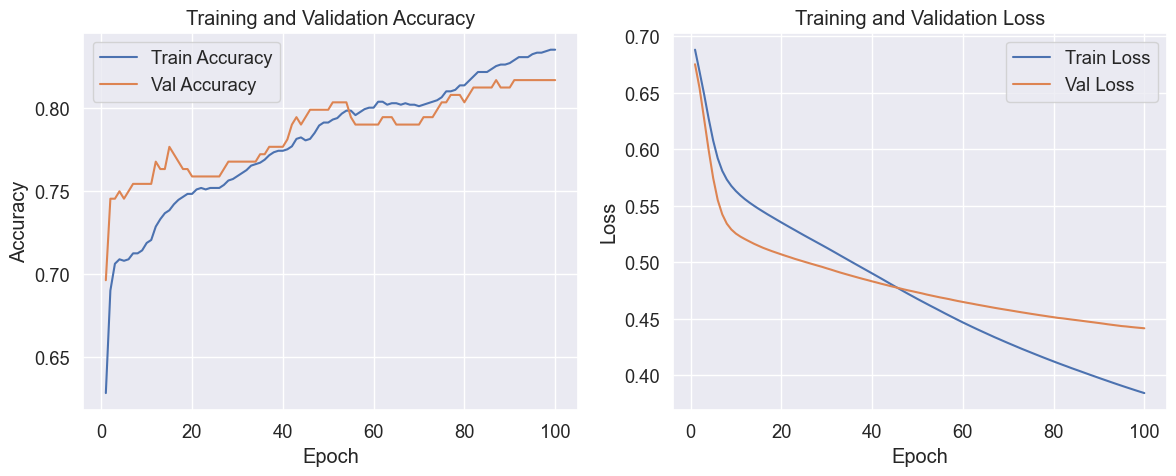

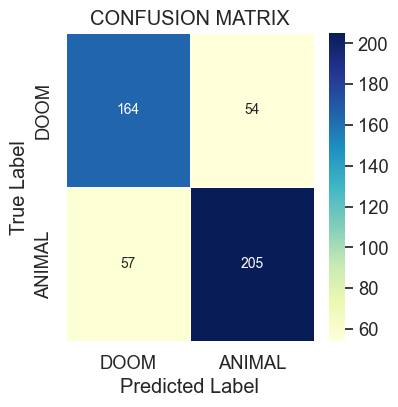

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.74      0.75      0.75       218
      ANIMAL       0.79      0.78      0.79       262

    accuracy                           0.77       480
   macro avg       0.77      0.77      0.77       480
weighted avg       0.77      0.77      0.77       480



In [106]:
plot_training_history(hist)
Confusion_Matrix(model2, test_x, test_y)

### MODEL 3

In [107]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

with tf.device('/GPU:0'):
    hist = my_train_loop(model3, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac, ac)

Epoch 1/100   Train Accuracy: 0.584602 Train Loss: 0.684620   Val Accuracy: 0.571429 Val Loss: 0.671906
Epoch 2/100   Train Accuracy: 0.634736 Train Loss: 0.650401   Val Accuracy: 0.683036 Val Loss: 0.639582
Epoch 3/100   Train Accuracy: 0.705461 Train Loss: 0.603994   Val Accuracy: 0.678571 Val Loss: 0.620439
Epoch 4/100   Train Accuracy: 0.713518 Train Loss: 0.566668   Val Accuracy: 0.678571 Val Loss: 0.621465
Epoch 5/100   Train Accuracy: 0.718890 Train Loss: 0.545812   Val Accuracy: 0.683036 Val Loss: 0.623960
Epoch 6/100   Train Accuracy: 0.725157 Train Loss: 0.533174   Val Accuracy: 0.705357 Val Loss: 0.618485
Epoch 7/100   Train Accuracy: 0.733214 Train Loss: 0.523094   Val Accuracy: 0.705357 Val Loss: 0.613631
Epoch 8/100   Train Accuracy: 0.739481 Train Loss: 0.514728   Val Accuracy: 0.700893 Val Loss: 0.610935
Epoch 9/100   Train Accuracy: 0.748433 Train Loss: 0.508101   Val Accuracy: 0.700893 Val Loss: 0.609385
Epoch 10/100   Train Accuracy: 0.752014 Train Loss: 0.502254   V

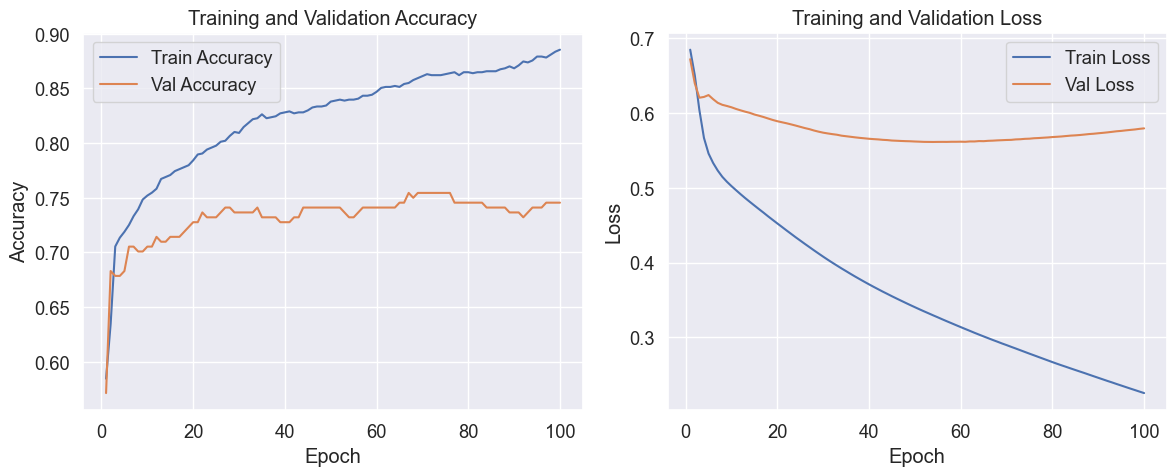

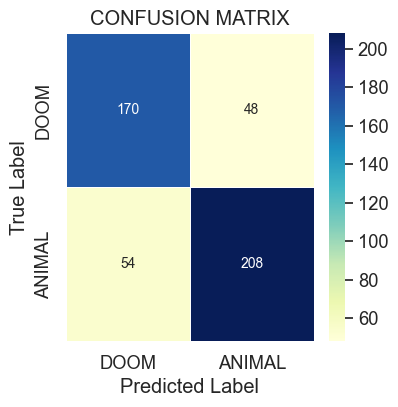

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.76      0.78      0.77       218
      ANIMAL       0.81      0.79      0.80       262

    accuracy                           0.79       480
   macro avg       0.79      0.79      0.79       480
weighted avg       0.79      0.79      0.79       480



In [108]:
plot_training_history(hist)
Confusion_Matrix(model3, test_x, test_y)

### MODEL 4

In [111]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
with tf.device('/GPU:0'):
    hist = my_train_loop(model4, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac, ac)

Epoch 1/100   Train Accuracy: 0.513876 Train Loss: 0.697548   Val Accuracy: 0.531250 Val Loss: 0.690260
Epoch 2/100   Train Accuracy: 0.549687 Train Loss: 0.688668   Val Accuracy: 0.665179 Val Loss: 0.680760
Epoch 3/100   Train Accuracy: 0.660698 Train Loss: 0.679658   Val Accuracy: 0.718750 Val Loss: 0.673209
Epoch 4/100   Train Accuracy: 0.699194 Train Loss: 0.670845   Val Accuracy: 0.709821 Val Loss: 0.666075
Epoch 5/100   Train Accuracy: 0.703671 Train Loss: 0.662004   Val Accuracy: 0.709821 Val Loss: 0.658457
Epoch 6/100   Train Accuracy: 0.709937 Train Loss: 0.653355   Val Accuracy: 0.709821 Val Loss: 0.651676
Epoch 7/100   Train Accuracy: 0.718890 Train Loss: 0.645005   Val Accuracy: 0.709821 Val Loss: 0.645382
Epoch 8/100   Train Accuracy: 0.716204 Train Loss: 0.637007   Val Accuracy: 0.700893 Val Loss: 0.639360
Epoch 9/100   Train Accuracy: 0.714414 Train Loss: 0.629484   Val Accuracy: 0.696429 Val Loss: 0.633916
Epoch 10/100   Train Accuracy: 0.712623 Train Loss: 0.622394   V

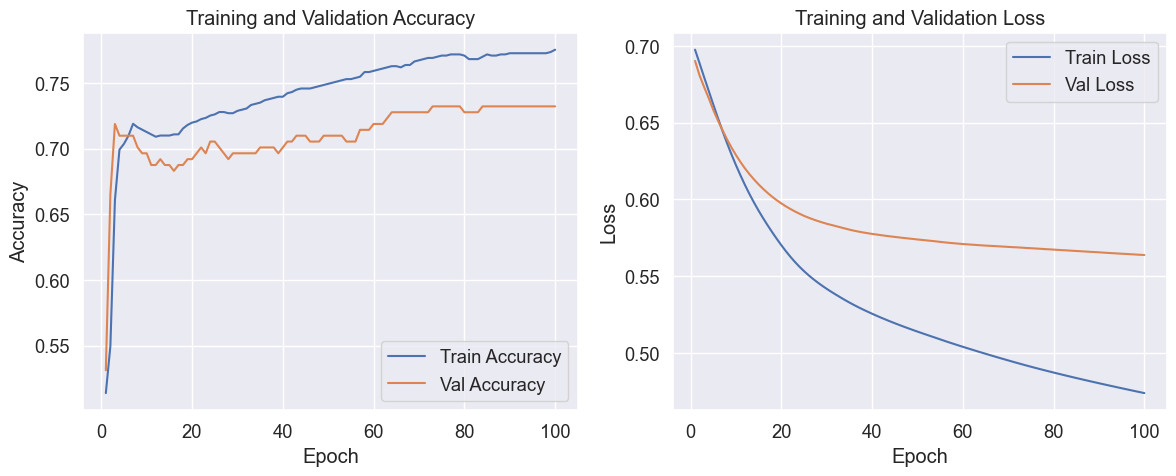

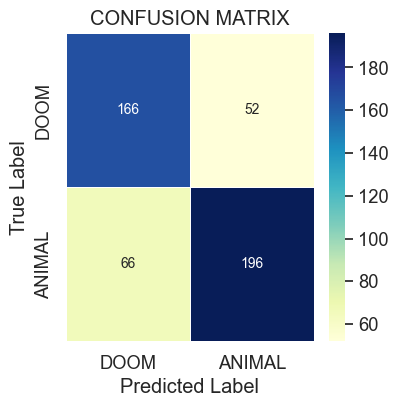

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.72      0.76      0.74       218
      ANIMAL       0.79      0.75      0.77       262

    accuracy                           0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.76      0.75      0.75       480



In [112]:
plot_training_history(hist)
Confusion_Matrix(model4, test_x, test_y)

# RNN

### Загрузка набора данных

In [128]:
data = tf.keras.utils.image_dataset_from_directory(
    'C:\\Users\\dimag\\doom-crossing',
    image_size=(64, 64),
    batch_size=None
)
data = data.map(lambda x,y: (x/255, y))

x_list = []
y_list = []

for x, y in data:
    x_list.append(x.numpy())
    y_list.append(y.numpy())

x_data = np.stack(x_list)
x_data = x_data.reshape((x_data.shape[0], 64, 64 * 3)) 
y_data = np.stack(y_list)

Found 1597 files belonging to 2 classes.


In [129]:
split = train_test_split(x_data, y_data, test_size=0.3, random_state=46)
(train_x, test_x, train_y, test_y) = split

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1117, 64, 192)
(1117,)
(480, 64, 192)
(480,)


### Параметры обучения

In [131]:
# Оптимизатор и функция потерь
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
ac = tf.keras.metrics.BinaryAccuracy()

# Параметры цикла
epochs = 100
batch_size = 100

### MODEL 1

In [132]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 192)),  # 64 строк, 64*3 каналов
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(1, activation='sigmoid')  # для бинарной классификации
])

In [133]:
with tf.device('/GPU:0'): # АТАВИЗМ
    hist = my_train_loop(model1, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac)

Epoch 1/100   Train Accuracy: 0.481523 Train Loss: 0.732722   Val Accuracy: 0.964519 Val Loss: 0.754919
Epoch 2/100   Train Accuracy: 0.487122 Train Loss: 0.729768   Val Accuracy: 0.964527 Val Loss: 0.751228
Epoch 3/100   Train Accuracy: 0.487122 Train Loss: 0.727242   Val Accuracy: 0.964535 Val Loss: 0.748043
Epoch 4/100   Train Accuracy: 0.488242 Train Loss: 0.725044   Val Accuracy: 0.964543 Val Loss: 0.745148
Epoch 5/100   Train Accuracy: 0.496081 Train Loss: 0.723082   Val Accuracy: 0.964551 Val Loss: 0.742629
Epoch 6/100   Train Accuracy: 0.502800 Train Loss: 0.721278   Val Accuracy: 0.964559 Val Loss: 0.740300
Epoch 7/100   Train Accuracy: 0.502800 Train Loss: 0.719577   Val Accuracy: 0.964567 Val Loss: 0.738148
Epoch 8/100   Train Accuracy: 0.505039 Train Loss: 0.717947   Val Accuracy: 0.964575 Val Loss: 0.736136
Epoch 9/100   Train Accuracy: 0.509519 Train Loss: 0.716370   Val Accuracy: 0.964582 Val Loss: 0.734213
Epoch 10/100   Train Accuracy: 0.511758 Train Loss: 0.714836   V

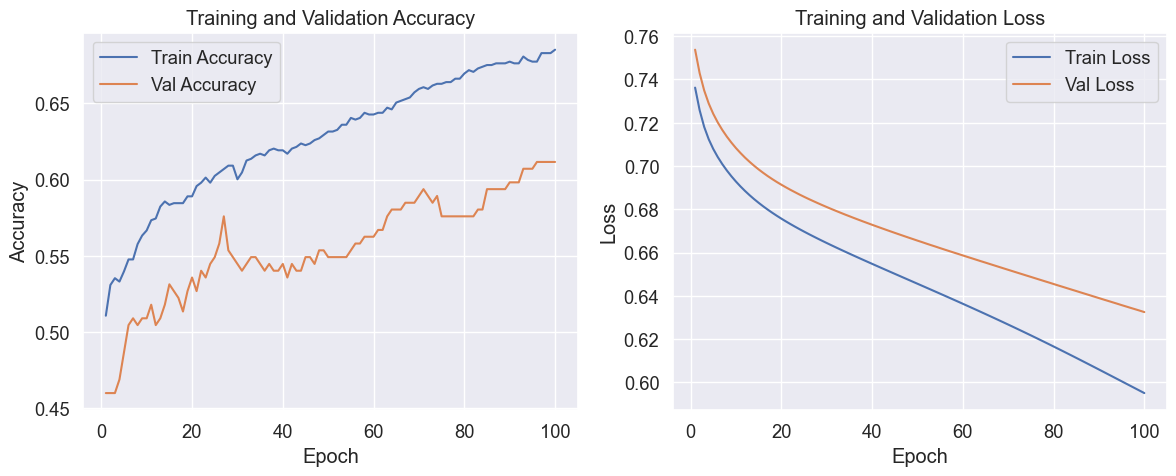

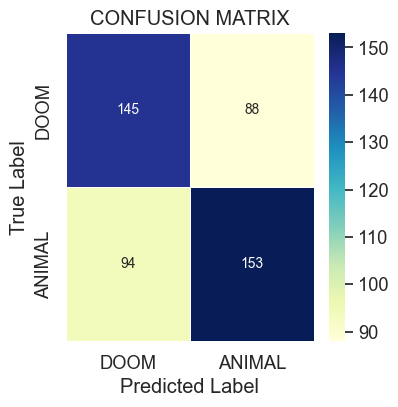

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.61      0.62      0.61       233
      ANIMAL       0.63      0.62      0.63       247

    accuracy                           0.62       480
   macro avg       0.62      0.62      0.62       480
weighted avg       0.62      0.62      0.62       480



In [217]:
plot_training_history(hist)
Confusion_Matrix(model1, test_x, test_y)

### MODEL 2

In [134]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 192)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [135]:
with tf.device('/GPU:0'): # АТАВИЗМ
    hist = my_train_loop(model2, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac)

Epoch 1/100   Train Accuracy: 0.520717 Train Loss: 0.730691   Val Accuracy: 0.965293 Val Loss: 0.719728
Epoch 2/100   Train Accuracy: 0.513998 Train Loss: 0.700920   Val Accuracy: 0.965300 Val Loss: 0.696919
Epoch 3/100   Train Accuracy: 0.555431 Train Loss: 0.688325   Val Accuracy: 0.965308 Val Loss: 0.688899
Epoch 4/100   Train Accuracy: 0.585666 Train Loss: 0.683945   Val Accuracy: 0.965316 Val Loss: 0.685039
Epoch 5/100   Train Accuracy: 0.611422 Train Loss: 0.680682   Val Accuracy: 0.965323 Val Loss: 0.681639
Epoch 6/100   Train Accuracy: 0.618141 Train Loss: 0.677186   Val Accuracy: 0.965331 Val Loss: 0.678397
Epoch 7/100   Train Accuracy: 0.633819 Train Loss: 0.673705   Val Accuracy: 0.965338 Val Loss: 0.675379
Epoch 8/100   Train Accuracy: 0.631579 Train Loss: 0.670487   Val Accuracy: 0.965346 Val Loss: 0.672587
Epoch 9/100   Train Accuracy: 0.633819 Train Loss: 0.667674   Val Accuracy: 0.965353 Val Loss: 0.670032
Epoch 10/100   Train Accuracy: 0.634938 Train Loss: 0.665288   V

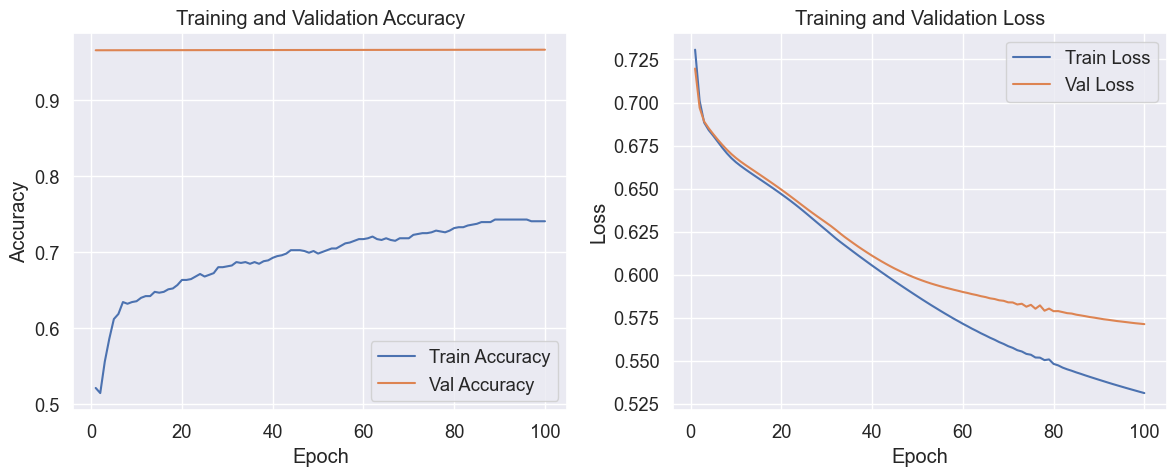

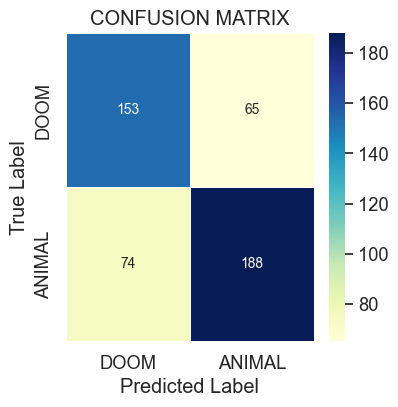

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.67      0.70      0.69       218
      ANIMAL       0.74      0.72      0.73       262

    accuracy                           0.71       480
   macro avg       0.71      0.71      0.71       480
weighted avg       0.71      0.71      0.71       480



In [136]:
plot_training_history(hist)
Confusion_Matrix(model2, test_x, test_y)

### MODEL 3

In [137]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 192)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [138]:
with tf.device('/GPU:0'): # АТАВИЗМ
    hist = my_train_loop(model3, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac)

Epoch 1/100   Train Accuracy: 0.513998 Train Loss: 0.779604   Val Accuracy: 0.966033 Val Loss: 0.724690
Epoch 2/100   Train Accuracy: 0.497200 Train Loss: 0.710348   Val Accuracy: 0.966041 Val Loss: 0.691271
Epoch 3/100   Train Accuracy: 0.506159 Train Loss: 0.697831   Val Accuracy: 0.966048 Val Loss: 0.687223
Epoch 4/100   Train Accuracy: 0.535274 Train Loss: 0.692785   Val Accuracy: 0.966055 Val Loss: 0.680677
Epoch 5/100   Train Accuracy: 0.559910 Train Loss: 0.685810   Val Accuracy: 0.966062 Val Loss: 0.675884
Epoch 6/100   Train Accuracy: 0.589026 Train Loss: 0.681368   Val Accuracy: 0.966070 Val Loss: 0.672611
Epoch 7/100   Train Accuracy: 0.601344 Train Loss: 0.678101   Val Accuracy: 0.966077 Val Loss: 0.669170
Epoch 8/100   Train Accuracy: 0.615901 Train Loss: 0.674895   Val Accuracy: 0.966084 Val Loss: 0.665676
Epoch 9/100   Train Accuracy: 0.625980 Train Loss: 0.671798   Val Accuracy: 0.966091 Val Loss: 0.662461
Epoch 10/100   Train Accuracy: 0.631579 Train Loss: 0.668866   V

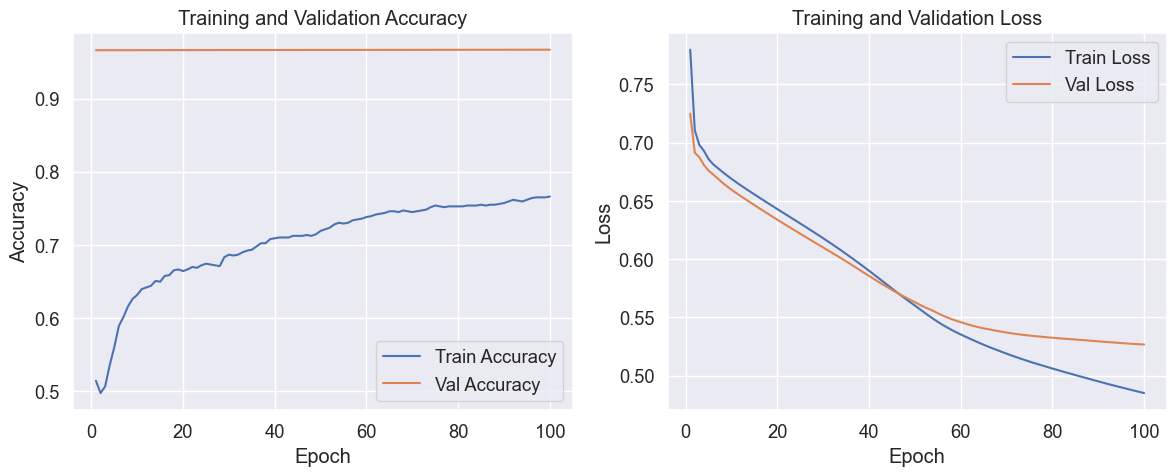

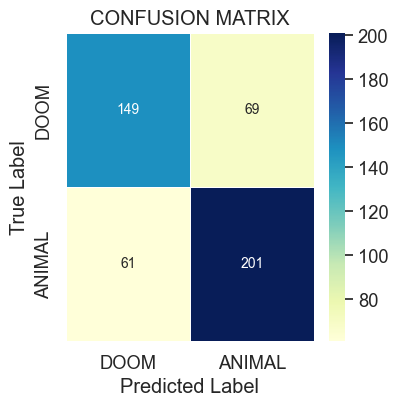

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.71      0.68      0.70       218
      ANIMAL       0.74      0.77      0.76       262

    accuracy                           0.73       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.73      0.73      0.73       480



In [139]:
plot_training_history(hist)
Confusion_Matrix(model3, test_x, test_y)

### MODEL 4

In [140]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 192)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [141]:
with tf.device('/GPU:0'): # АТАВИЗМ
    hist = my_train_loop(model4, epochs, batch_size, optimizer, loss_fn, train_x, train_y, ac)

Epoch 1/100   Train Accuracy: 0.508399 Train Loss: 0.702119   Val Accuracy: 0.966743 Val Loss: 0.696675
Epoch 2/100   Train Accuracy: 0.545353 Train Loss: 0.689177   Val Accuracy: 0.966750 Val Loss: 0.684835
Epoch 3/100   Train Accuracy: 0.602464 Train Loss: 0.682098   Val Accuracy: 0.966757 Val Loss: 0.678726
Epoch 4/100   Train Accuracy: 0.622620 Train Loss: 0.677426   Val Accuracy: 0.966764 Val Loss: 0.674663
Epoch 5/100   Train Accuracy: 0.625980 Train Loss: 0.673308   Val Accuracy: 0.966771 Val Loss: 0.671423
Epoch 6/100   Train Accuracy: 0.640538 Train Loss: 0.669453   Val Accuracy: 0.966778 Val Loss: 0.668610
Epoch 7/100   Train Accuracy: 0.643897 Train Loss: 0.665806   Val Accuracy: 0.966785 Val Loss: 0.666017
Epoch 8/100   Train Accuracy: 0.647256 Train Loss: 0.662315   Val Accuracy: 0.966792 Val Loss: 0.663518
Epoch 9/100   Train Accuracy: 0.655095 Train Loss: 0.658929   Val Accuracy: 0.966798 Val Loss: 0.661024
Epoch 10/100   Train Accuracy: 0.658455 Train Loss: 0.655579   V

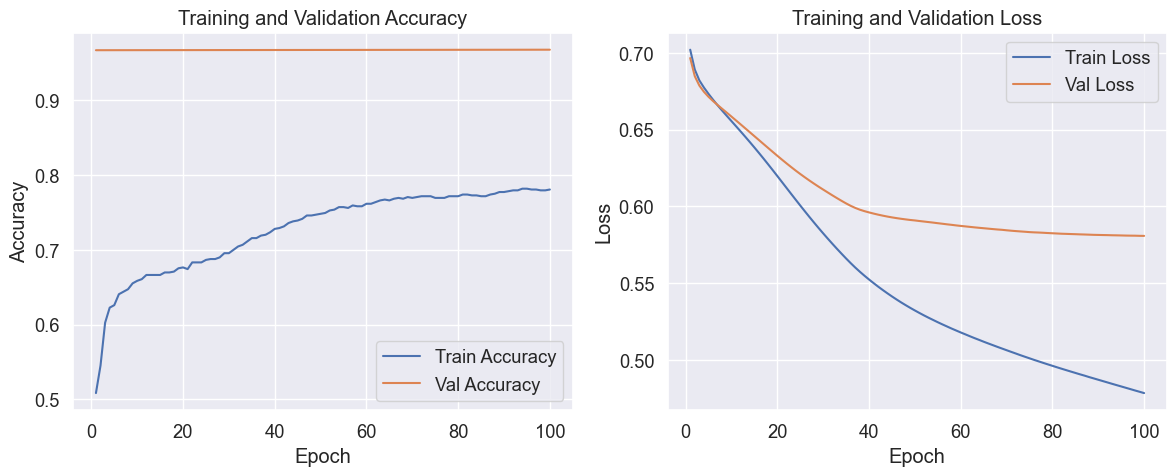

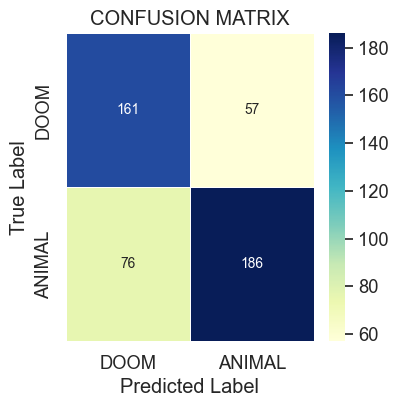

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.68      0.74      0.71       218
      ANIMAL       0.77      0.71      0.74       262

    accuracy                           0.72       480
   macro avg       0.72      0.72      0.72       480
weighted avg       0.73      0.72      0.72       480



In [142]:
plot_training_history(hist)
Confusion_Matrix(model4, test_x, test_y)

# Используем обучение без учителя

In [10]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from livelossplot import PlotLossesKeras # Великолепная штука
#### https://github.com/stared/livelossplot

In [11]:
# Опять грузить эти данные)
data = tf.keras.utils.image_dataset_from_directory(
    'C:\\Users\\dimag\\doom-crossing',
    image_size=(64, 64),
    batch_size=None
)
data = data.map(lambda x,y: (x/255, y))

x_list = []
y_list = []

for x, y in data:
    x_list.append(x.numpy())
    y_list.append(y.numpy())

x_data = np.stack(x_list)
y_data = np.stack(y_list)

Found 1597 files belonging to 2 classes.


In [44]:
split = train_test_split(x_data, y_data, test_size=0.3, random_state=46)
(train_x, test_x, train_y, test_y) = split

# Иммитируем ситуацию, когда 95% обучающего набора не аннотированы
split = train_test_split(train_x, train_y, test_size=0.95, random_state=46) 
(train_anot_x, _ , train_anot_y, _) = split

print(train_x.shape)
print(train_y.shape)
print(train_anot_x.shape)
print(train_anot_y.shape)
print(test_x.shape)
print(test_y.shape)

(1117, 64, 64, 3)
(1117,)
(55, 64, 64, 3)
(55,)
(480, 64, 64, 3)
(480,)


### Основная модель обучения без учителя

In [57]:
input_img = Input(shape=(64, 64, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
x = MaxPooling2D((2, 2), padding='same')(x)                        

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)   
x = MaxPooling2D((2, 2), padding='same')(x)                         

x = UpSampling2D((2, 2))(x)                                        
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  

x = UpSampling2D((2, 2))(x)                                           
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) 
autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 up_sampling2d_8 (UpSampling  (None, 32, 32, 64)       0   

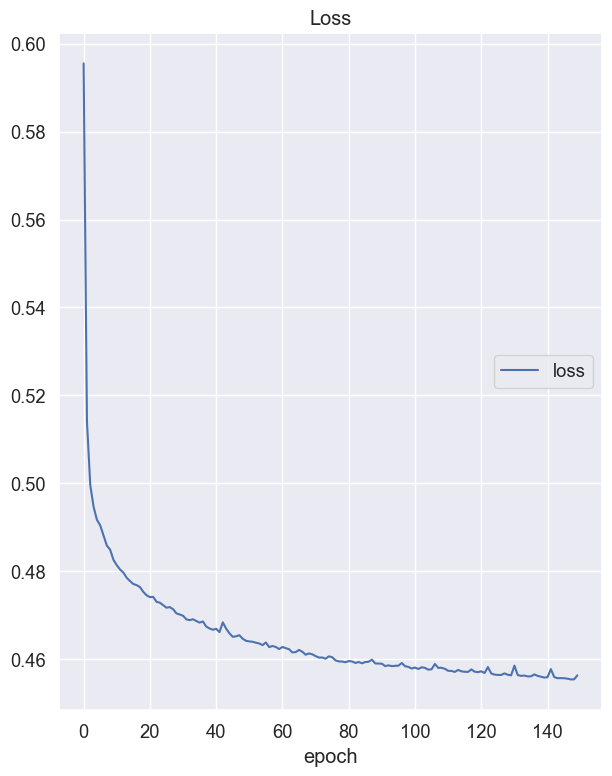

Loss
	loss             	 (min:    0.455, max:    0.596, cur:    0.456)
35/35 [==============================] - 0s 8ms/step - loss: 0.4564


In [58]:
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
autoencoder.fit(train_x, train_x, epochs=150, batch_size=32, shuffle=True,callbacks=[PlotLossesKeras()])

### Модель с одним предобученным слоем 

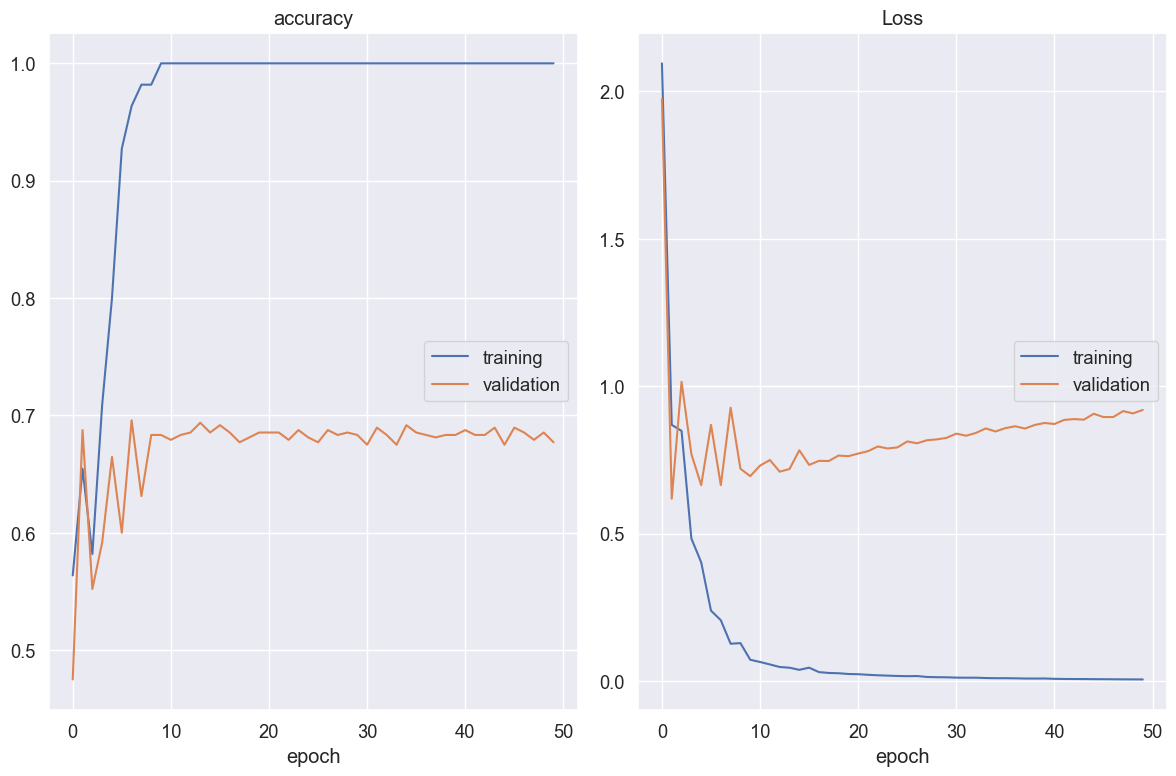

accuracy
	training         	 (min:    0.564, max:    1.000, cur:    1.000)
	validation       	 (min:    0.475, max:    0.696, cur:    0.677)
Loss
	training         	 (min:    0.006, max:    2.095, cur:    0.006)
	validation       	 (min:    0.619, max:    1.975, cur:    0.920)
11/11 [==============================] - 0s 38ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.9197 - val_accuracy: 0.6771


In [59]:
# Воспользуемся весами первого сверточного слоя
encoder_conv_layer = autoencoder.layers[1] # Первый сверточный слой (32 фильтра)
encoder_weights = encoder_conv_layer.get_weights()


# И определим новую модель
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3), trainable=False))
classifier.layers[0].set_weights(encoder_weights) # <--------------------------------------------------- те самые веса

classifier.add(MaxPooling2D((2, 2), padding='same'))      


classifier.add(Flatten())
classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

classifier.fit(train_anot_x, train_anot_y, epochs=50, batch_size=5,callbacks=[PlotLossesKeras()], validation_data=[test_x, test_y])

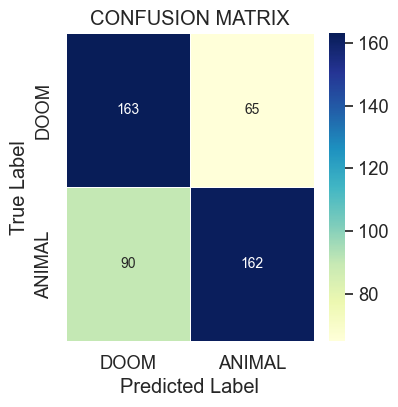

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.64      0.71      0.68       228
      ANIMAL       0.71      0.64      0.68       252

    accuracy                           0.68       480
   macro avg       0.68      0.68      0.68       480
weighted avg       0.68      0.68      0.68       480



In [60]:
Confusion_Matrix(classifier, test_x, test_y)

### Модель с двумя предобученными слоями

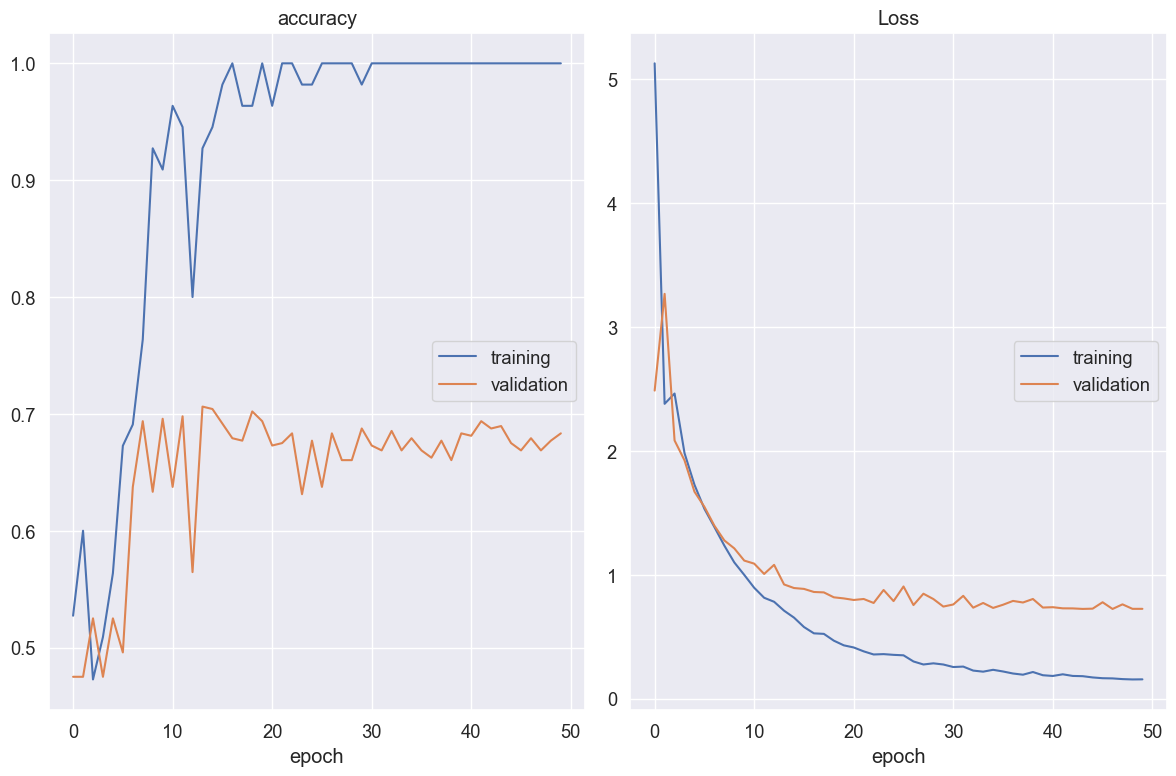

accuracy
	training         	 (min:    0.473, max:    1.000, cur:    1.000)
	validation       	 (min:    0.475, max:    0.706, cur:    0.683)
Loss
	training         	 (min:    0.155, max:    5.129, cur:    0.155)
	validation       	 (min:    0.724, max:    3.268, cur:    0.725)
11/11 [==============================] - 0s 41ms/step - loss: 0.1554 - accuracy: 1.0000 - val_loss: 0.7247 - val_accuracy: 0.6833


In [61]:
# Получаем веса из автоэнкодера
encoder_conv1 = autoencoder.layers[1]  # Первый сверточный слой (32 фильтра)
encoder_conv2 = autoencoder.layers[3]  # Второй сверточный слой (64 фильтра)

weights_conv1 = encoder_conv1.get_weights()
weights_conv2 = encoder_conv2.get_weights()

# Создаем классификатор с двумя предобученными слоями
classifier = Sequential()

# Первый слой (замороженный, с весами из автоэнкодера)
classifier.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3), trainable=False))
classifier.layers[0].set_weights(weights_conv1)

classifier.add(MaxPooling2D((2, 2), padding='same'))

# Второй слой (замороженный, с весами из автоэнкодера)
classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same', trainable=False))
classifier.layers[2].set_weights(weights_conv2) 

classifier.add(MaxPooling2D((2, 2), padding='same'))

# Слои классификатора
classifier.add(Flatten())
classifier.add(Dense(128, activation='relu', kernel_regularizer='l2'))
classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(train_anot_x, train_anot_y, epochs=50, batch_size=5,callbacks=[PlotLossesKeras()], validation_data=[test_x, test_y])

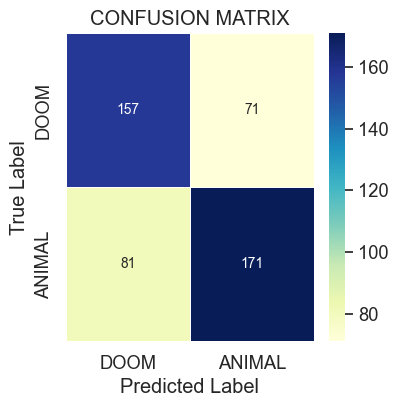

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.66      0.69      0.67       228
      ANIMAL       0.71      0.68      0.69       252

    accuracy                           0.68       480
   macro avg       0.68      0.68      0.68       480
weighted avg       0.68      0.68      0.68       480



In [62]:
Confusion_Matrix(classifier, test_x, test_y)

### Модель без предобучения

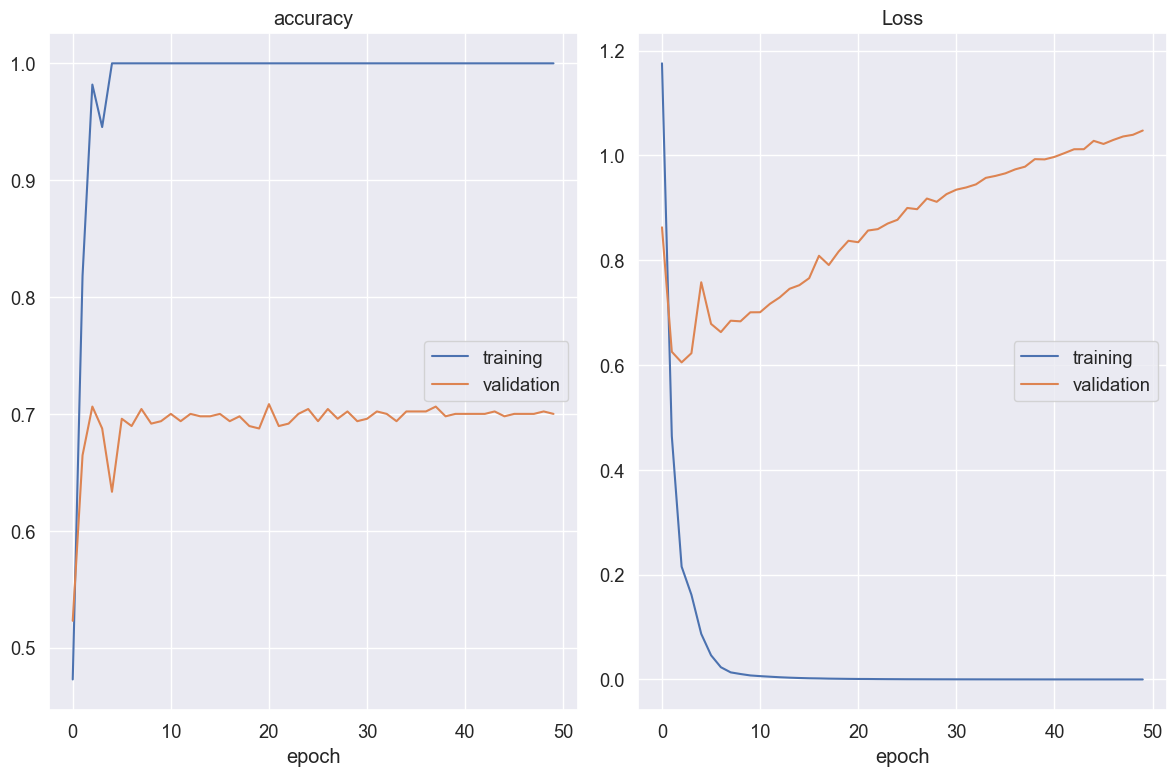

accuracy
	training         	 (min:    0.473, max:    1.000, cur:    1.000)
	validation       	 (min:    0.523, max:    0.708, cur:    0.700)
Loss
	training         	 (min:    0.000, max:    1.176, cur:    0.000)
	validation       	 (min:    0.605, max:    1.047, cur:    1.047)
11/11 [==============================] - 0s 41ms/step - loss: 8.3154e-05 - accuracy: 1.0000 - val_loss: 1.0473 - val_accuracy: 0.7000


In [63]:
classifier_random = Sequential()
classifier_random.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))

classifier_random.add(MaxPooling2D((2, 2), padding='same'))
classifier_random.add(Flatten())
classifier_random.add(Dense(64, activation='relu'))
classifier_random.add(Dense(1, activation='sigmoid'))

classifier_random.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier_random.fit(train_anot_x, train_anot_y,
                      epochs=50, batch_size=5,
                      callbacks=[PlotLossesKeras()], validation_data=[test_x, test_y])

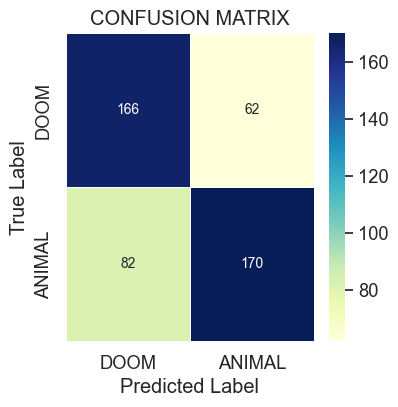

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.67      0.73      0.70       228
      ANIMAL       0.73      0.67      0.70       252

    accuracy                           0.70       480
   macro avg       0.70      0.70      0.70       480
weighted avg       0.70      0.70      0.70       480



In [64]:
Confusion_Matrix(classifier_random, test_x, test_y)

### Более глубокая модель обучения без учителя Включая skip connection

In [67]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model

def build_deep_autoencoder(input_shape=(64, 64, 3)):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x_pool1 = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x_pool1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x_pool2 = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same')(x_pool2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    encoded = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x_pool1_adjusted = Conv2D(64, (1, 1), padding='same')(x_pool1)
    x = Concatenate()([x, x_pool1_adjusted])

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder

deep_autoencoder = build_deep_autoencoder()
deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

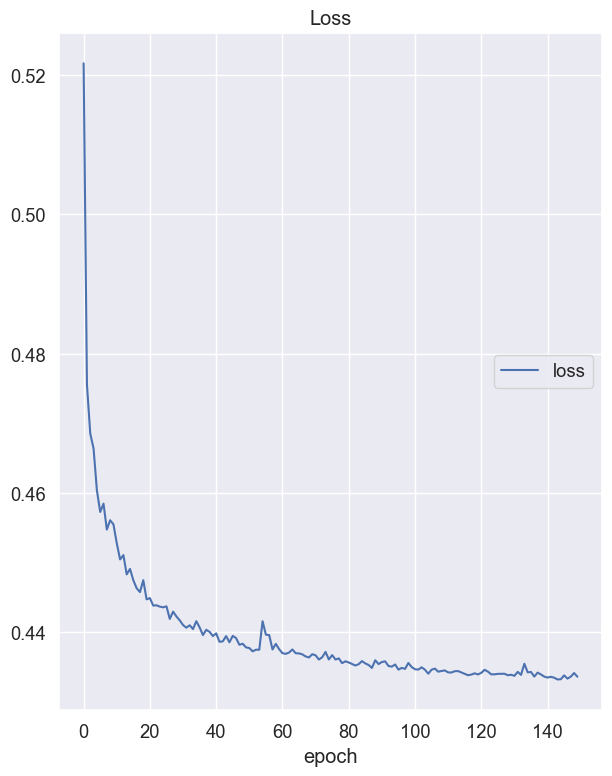

Loss
	loss             	 (min:    0.433, max:    0.522, cur:    0.434)
35/35 [==============================] - 1s 17ms/step - loss: 0.4336


In [68]:
deep_autoencoder.fit(train_x, train_x, epochs=150, batch_size=32, shuffle=True,callbacks=[PlotLossesKeras()])

In [95]:
# Получаем веса из автоэнкодера (предполагая, что deep_autoencoder уже обучен)
encoder_weights_1 = deep_autoencoder.layers[1].get_weights()  # Первый Conv2D (32 фильтра)
encoder_weights_2 = deep_autoencoder.layers[8].get_weights()  # Второй Conv2D (64 фильтра)
encoder_weights_3 = deep_autoencoder.layers[15].get_weights() # Третий Conv2D (128 фильтров)

In [94]:
deep_autoencoder.layers[15]

### Глубокая модель с несколькими предобученными слоями

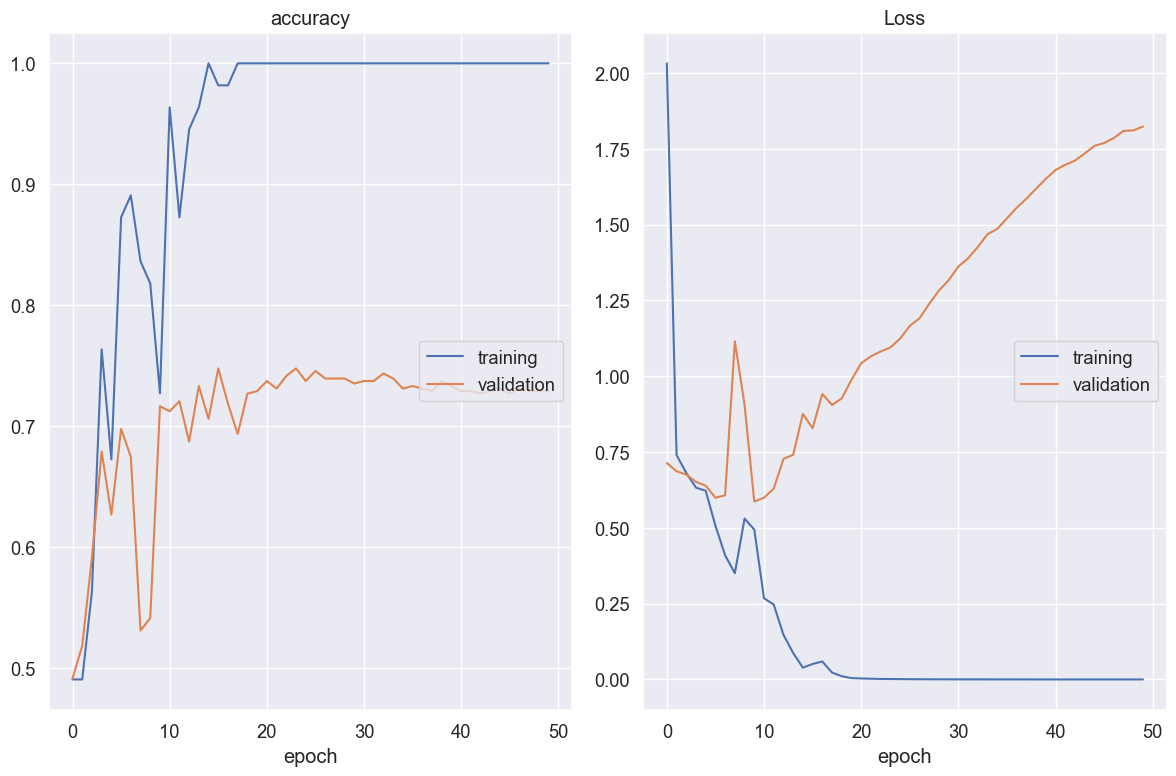

accuracy
	training         	 (min:    0.491, max:    1.000, cur:    1.000)
	validation       	 (min:    0.492, max:    0.748, cur:    0.729)
Loss
	training         	 (min:    0.000, max:    2.032, cur:    0.000)
	validation       	 (min:    0.587, max:    1.823, cur:    1.823)
11/11 [==============================] - 0s 46ms/step - loss: 1.9654e-05 - accuracy: 1.0000 - val_loss: 1.8234 - val_accuracy: 0.7292


In [96]:
Model1 = Sequential()

Model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', 
          input_shape=(64, 64, 3), name='pretrained_conv1'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same', name='pretrained_conv2'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='pretrained_conv3'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
Model1.get_layer('pretrained_conv1').set_weights(encoder_weights_1)
Model1.get_layer('pretrained_conv2').set_weights(encoder_weights_2)
Model1.get_layer('pretrained_conv3').set_weights(encoder_weights_3)

Model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model1.fit(train_anot_x, train_anot_y, epochs=50, batch_size=5, callbacks=[PlotLossesKeras()], validation_data=(test_x, test_y))

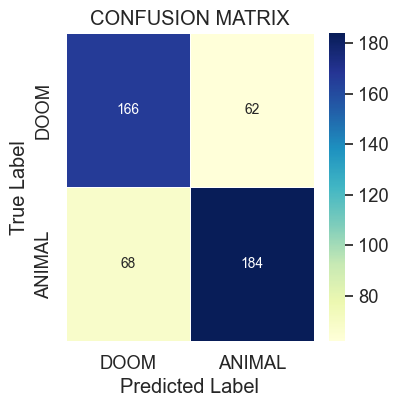

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.71      0.73      0.72       228
      ANIMAL       0.75      0.73      0.74       252

    accuracy                           0.73       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.73      0.73      0.73       480



In [97]:
Confusion_Matrix(Model1, test_x, test_y)

### Глубокая модель с одним предобученным слоем

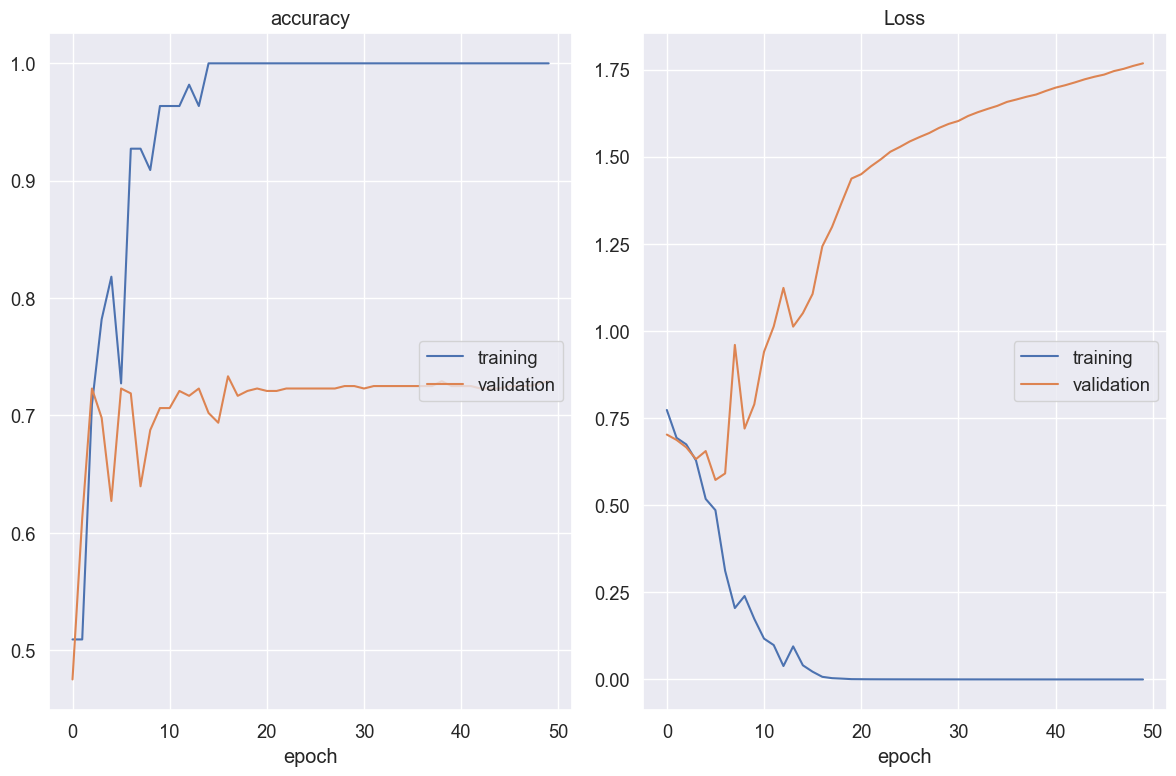

accuracy
	training         	 (min:    0.509, max:    1.000, cur:    1.000)
	validation       	 (min:    0.475, max:    0.733, cur:    0.729)
Loss
	training         	 (min:    0.000, max:    0.773, cur:    0.000)
	validation       	 (min:    0.572, max:    1.768, cur:    1.768)
11/11 [==============================] - 0s 41ms/step - loss: 8.3395e-05 - accuracy: 1.0000 - val_loss: 1.7678 - val_accuracy: 0.7292


In [100]:
Model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', 
          input_shape=(64, 64, 3), name='pretrained_conv1'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
# Загружаем веса только для первого слоя Model2
Model2.get_layer('pretrained_conv1').set_weights(encoder_weights_1)

Model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model2.fit(train_anot_x, train_anot_y, epochs=50, batch_size=5, callbacks=[PlotLossesKeras()], validation_data=(test_x, test_y))

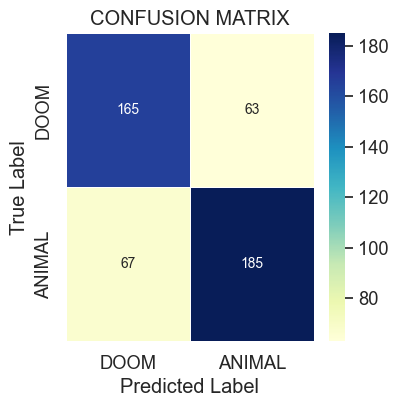

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.71      0.72      0.72       228
      ANIMAL       0.75      0.73      0.74       252

    accuracy                           0.73       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.73      0.73      0.73       480



In [101]:
Confusion_Matrix(Model2, test_x, test_y)

### Модель обученная с нуля

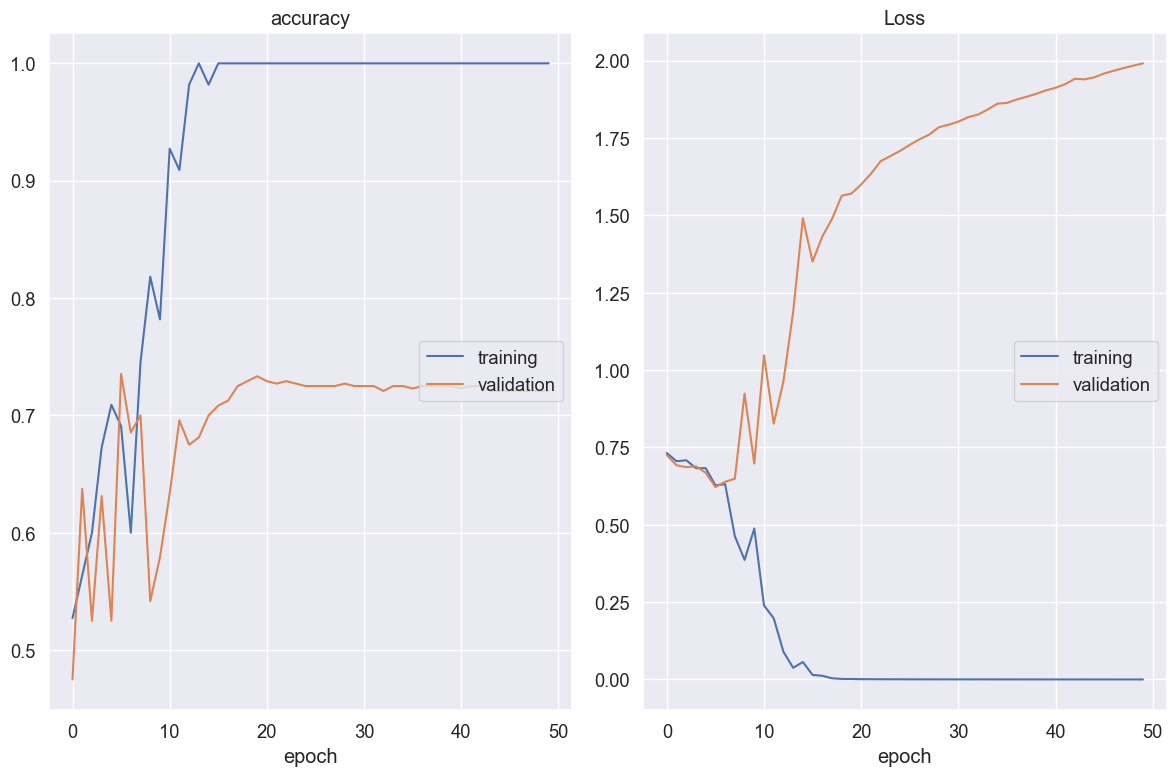

accuracy
	training         	 (min:    0.527, max:    1.000, cur:    1.000)
	validation       	 (min:    0.475, max:    0.735, cur:    0.721)
Loss
	training         	 (min:    0.000, max:    0.732, cur:    0.000)
	validation       	 (min:    0.622, max:    1.991, cur:    1.991)
11/11 [==============================] - 0s 43ms/step - loss: 1.1872e-04 - accuracy: 1.0000 - val_loss: 1.9914 - val_accuracy: 0.7208


In [102]:
Model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

Model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model3.fit(train_anot_x, train_anot_y, epochs=50, batch_size=5, callbacks=[PlotLossesKeras()], validation_data=(test_x, test_y))

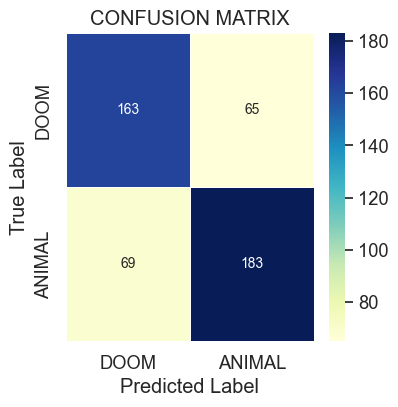

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        DOOM       0.70      0.71      0.71       228
      ANIMAL       0.74      0.73      0.73       252

    accuracy                           0.72       480
   macro avg       0.72      0.72      0.72       480
weighted avg       0.72      0.72      0.72       480



In [103]:
Confusion_Matrix(Model3, test_x, test_y)

# Перенос обучения

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Layer, Input
from tensorflow.keras.layers import Flatten, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [9]:
data = tf.keras.utils.image_dataset_from_directory(
    'C:\\Users\\dimag\\doom-crossing',
    image_size=(256, 256),
    batch_size=None
)
data = data.map(lambda x,y: (x/255, y))

x_list = []
y_list = []

for x, y in data:
    x_list.append(x.numpy())
    y_list.append(y.numpy())

x_data = np.stack(x_list)
y_data = np.stack(y_list)

split = train_test_split(x_data, y_data, test_size=0.3, random_state=46)
(train_x, test_x, train_y, test_y) = split

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

Found 1597 files belonging to 2 classes.
(1117, 256, 256, 3)
(1117,)
(480, 256, 256, 3)
(480,)


In [13]:
def load_resnet50(path="resnet50.hdf5"):
    model = ResNet50(include_top=False, input_shape=(256, 256, 3), pooling="avg")
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

In [40]:
def get_task():
    model = Sequential()
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

### Эксперимент 1 
Прямое использование модели, обученной для решения
исходной «Задачи А», для решения целевой «Задачи В»

In [35]:
base_model = ResNet50(include_top=False, input_tensor=Input(shape=(256, 256, 3)), pooling="avg")
x = base_model.output
output = Dense(1, activation='sigmoid')(x)  # бинарная классификация

model = Model(inputs=base_model.input, outputs=output)

# Замораживаем все слои ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Компиляция и обучение
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))

Epoch 1/100
35/35 [==============================] - 4s 79ms/step - loss: 0.6762 - accuracy: 0.5783 - val_loss: 0.6865 - val_accuracy: 0.5688
Epoch 2/100
35/35 [==============================] - 2s 61ms/step - loss: 0.6702 - accuracy: 0.5828 - val_loss: 0.6828 - val_accuracy: 0.5875
Epoch 3/100
35/35 [==============================] - 2s 60ms/step - loss: 0.6677 - accuracy: 0.5891 - val_loss: 0.6840 - val_accuracy: 0.5667
Epoch 4/100
35/35 [==============================] - 2s 61ms/step - loss: 0.6611 - accuracy: 0.6097 - val_loss: 0.6776 - val_accuracy: 0.5875
Epoch 5/100
35/35 [==============================] - 2s 61ms/step - loss: 0.6566 - accuracy: 0.6168 - val_loss: 0.6750 - val_accuracy: 0.6021
Epoch 6/100
35/35 [==============================] - 2s 61ms/step - loss: 0.6577 - accuracy: 0.6016 - val_loss: 0.6719 - val_accuracy: 0.6042
Epoch 7/100
35/35 [==============================] - 2s 61ms/step - loss: 0.6561 - accuracy: 0.6079 - val_loss: 0.6708 - val_accuracy: 0.6146
Epoch 

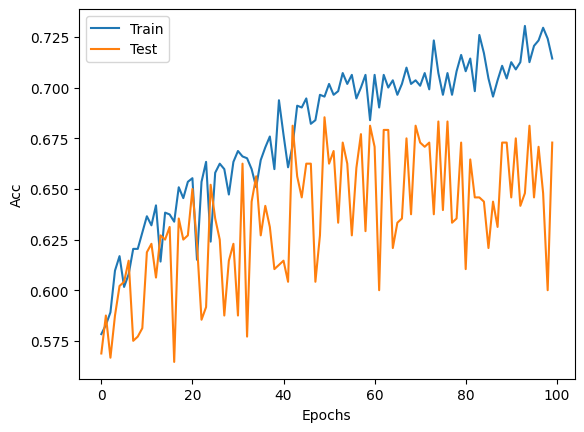

In [36]:
acc = model.history.history["accuracy"]; val_acc = model.history.history["val_accuracy"]
plt.plot(acc, label="Train")
plt.plot(val_acc, label="Test")
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

### Эксперимент 3
Использование модели, построенной для решения
исходной «Задачи А», в качестве фиксированного
метода извлечения признаков при построении модели,
решающей «Задачу В»

In [41]:
resnet50 = load_resnet50()
X_train_enc = resnet50.predict(train_x)
X_test_enc = resnet50.predict(test_x)

print("X train shape: %s"%str(X_train_enc.shape))
print("X test shape: %s"%str(X_test_enc.shape))

15/15 [==============================] - 1s 39ms/step
X train shape: (1117, 2048)
X test shape: (480, 2048)


In [42]:
task = get_task()
task.compile(loss="binary_crossentropy", optimizer=Adam(0.00001), metrics=["acc"])
task.fit(X_train_enc, train_y, epochs=100, batch_size=32,
         validation_data=(X_test_enc, test_y))

Epoch 1/100
35/35 [==============================] - 0s 5ms/step - loss: 1.1470 - acc: 0.4646 - val_loss: 0.7404 - val_acc: 0.4875
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7863 - acc: 0.4951 - val_loss: 0.7020 - val_acc: 0.5125
Epoch 3/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7475 - acc: 0.5121 - val_loss: 0.7123 - val_acc: 0.5125
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7460 - acc: 0.4942 - val_loss: 0.7088 - val_acc: 0.5125
Epoch 5/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7534 - acc: 0.4888 - val_loss: 0.7054 - val_acc: 0.5125
Epoch 6/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7272 - acc: 0.5255 - val_loss: 0.7078 - val_acc: 0.5125
Epoch 7/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7159 - acc: 0.5210 - val_loss: 0.7068 - val_acc: 0.5125
Epoch 8/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7216 - a

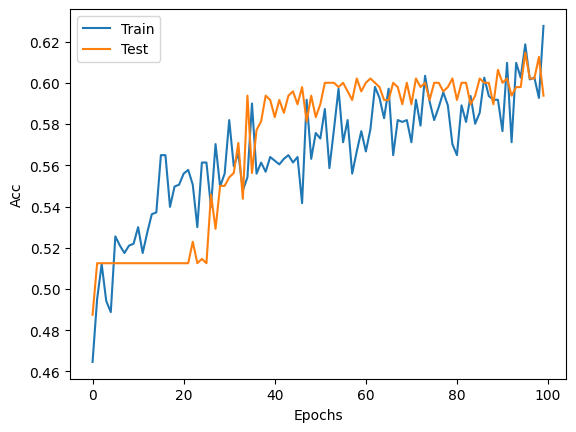

In [43]:
acc = task.history.history["acc"]; val_acc = task.history.history["val_acc"]
plt.plot(acc, label="Train")
plt.plot(val_acc, label="Test")
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

In [16]:
# Confusion_Matrix(model, test_x, test_y)

In [17]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Эксперимент 2
Использование структуры глубокой модели,
построенной для решения исходной «Задачи А», с целью
обучения аналогичной модели для решения «Задачи В»

In [18]:
def load_resnet50_no_weights(input_shape=(256, 256, 3)):
    model = ResNet50(include_top=False, weights=None, input_shape=input_shape, pooling="avg")
    for layer in model.layers:
        if layer.__class__.__name__ == "BatchNormalization":
            layer.trainable = False
    return model

In [19]:
# Вход
input_tensor = Input(shape=(256, 256, 3))

# Экстрактор признаков
resnet_model = load_resnet50_no_weights()
features = resnet_model(input_tensor)

# Классификатор
task_model = get_task()
output = task_model(features)

# Общая модель
full_model = Model(inputs=input_tensor, outputs=output)

In [20]:
full_model.compile(loss="binary_crossentropy", optimizer=Adam(0.00001), metrics=["acc"])
full_model.fit(train_x, train_y, epochs=100, batch_size=32,
         validation_data=(test_x, test_y))

Epoch 1/100
35/35 [==============================] - 10s 193ms/step - loss: 0.6970 - acc: 0.4718 - val_loss: 0.6927 - val_acc: 0.4896
Epoch 2/100
35/35 [==============================] - 5s 151ms/step - loss: 0.6928 - acc: 0.5121 - val_loss: 0.6917 - val_acc: 0.6687
Epoch 3/100
35/35 [==============================] - 5s 153ms/step - loss: 0.6919 - acc: 0.5309 - val_loss: 0.6909 - val_acc: 0.6646
Epoch 4/100
35/35 [==============================] - 5s 153ms/step - loss: 0.6915 - acc: 0.5309 - val_loss: 0.6888 - val_acc: 0.6458
Epoch 5/100
35/35 [==============================] - 5s 154ms/step - loss: 0.6867 - acc: 0.5819 - val_loss: 0.6797 - val_acc: 0.6750
Epoch 6/100
35/35 [==============================] - 5s 154ms/step - loss: 0.6699 - acc: 0.6276 - val_loss: 0.6485 - val_acc: 0.6313
Epoch 7/100
35/35 [==============================] - 5s 153ms/step - loss: 0.6282 - acc: 0.6365 - val_loss: 0.5971 - val_acc: 0.6917
Epoch 8/100
35/35 [==============================] - 5s 151ms/step -

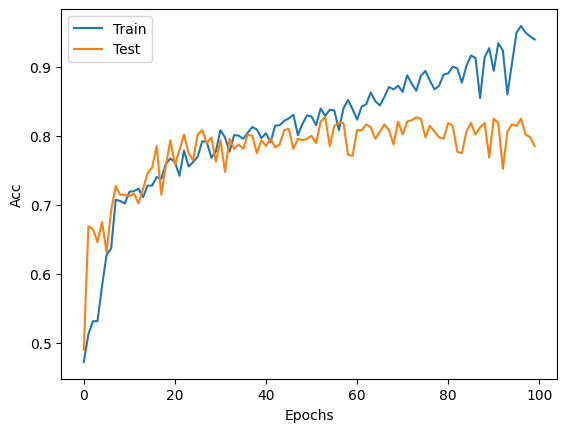

In [21]:
acc = full_model.history.history["acc"]; val_acc = full_model.history.history["val_acc"]
plt.plot(acc, label="Train")
plt.plot(val_acc, label="Test")
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

# LAB 5